In [1]:
import numpy as np

In [2]:
import networkx as nx

In [3]:
import os

In [4]:
import pandas as pd

In [5]:
from sklearn.utils import shuffle

In [6]:
from lib import graph

In [7]:
import scipy

In [8]:
from lib import coarsening

In [82]:
def coarsen(A, levels, self_connections=False):
    """
    Coarsen a graph, represented by its adjacency matrix A, at multiple
    levels.
    """
       
    graphs, parents = metis(A, levels)
    perms = compute_perm(parents)
    
    #print(perms)

    for i, A in enumerate(graphs):
       # print('enum index',i)
        M, M = A.shape

        if not self_connections:
            A = A.tocoo()
            A.setdiag(0)

        if i <= levels:
            A = perm_adjacency(A, perms[i])

        A = A.tocsr()
        A.eliminate_zeros()
        graphs[i] = A

        Mnew, Mnew = A.shape
        
        print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added),'
              '|E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))

    return graphs, perms[0] if levels > 0 else None

def coarsen_new(A, levels, self_connections=False):
    """
    Coarsen a graph, represented by its adjacency matrix A, at multiple
    levels.
    """
    
    nodelist = []
    
    graphs, parents = metis(A, levels)
    perms = compute_perm(parents)
    
    #print(perms)

    for i, A in enumerate(graphs):
       # print('enum index',i)
        M, M = A.shape

        if not self_connections:
            A = A.tocoo()
            A.setdiag(0)

        if i <= levels:
            A = perm_adjacency(A, perms[i])

        A = A.tocsr()
        A.eliminate_zeros()
        graphs[i] = A

        Mnew, Mnew = A.shape
        nodelist.append(Mnew)
    #         print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added),'
#               '|E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))

    return graphs, perms[0], nodelist if levels > 0 else None


def coarsen_adjust(A, levels, num_nodes, self_connections=False):
    """
    Coarsen a graph, represented by its adjacency matrix A, at multiple
    levels.
    """
    
    num_fake_nodes = num_nodes//(2**levels)
    
    print(num_fake_nodes)
    
    graphs, parents = metis_adjust(A, levels)
    perms = compute_perm_adjust(parents,num_fake_nodes)
    
    #print(perms)

    for i, A in enumerate(graphs):
       # print('enum index',i)
        M, M = A.shape

        if not self_connections:
            A = A.tocoo()
            A.setdiag(0)

        if i <= levels:
            A = perm_adjacency(A, perms[i])

        A = A.tocsr()
        A.eliminate_zeros()
        graphs[i] = A

        Mnew, Mnew = A.shape
        
        print('Layer {0}: M_{0} = |V| = {1} nodes ({2} added),'
              '|E| = {3} edges'.format(i, Mnew, Mnew-M, A.nnz//2))

    return graphs, perms[0] if levels > 0 else None

def metis(W, levels, rid=None):
    """
    Coarsen a graph multiple times using the METIS algorithm.

    INPUT
    W: symmetric sparse weight (adjacency) matrix
    levels: the number of coarsened graphs

    OUTPUT
    graph[0]: original graph of size N_1
    graph[2]: coarser graph of size N_2 < N_1
    graph[levels]: coarsest graph of Size N_levels < ... < N_2 < N_1
    parents[i] is a vector of size N_i with entries ranging from 1 to N_{i+1}
        which indicate the parents in the coarser graph[i+1]
    nd_sz{i} is a vector of size N_i that contains the size of the supernode in the graph{i}

    NOTE
    if "graph" is a list of length k, then "parents" will be a list of length k-1
    """

    N, N = W.shape
    if rid is None:
        rid = np.random.permutation(range(N)) #use randomstate in the add more fake nodes stage
    parents = []
    degree = W.sum(axis=0) - W.diagonal()
    graphs = []
    graphs.append(W)
    #supernode_size = np.ones(N)
    #nd_sz = [supernode_size]
    #count = 0

    #while N > maxsize:
    for _ in range(levels):

        #count += 1

        # CHOOSE THE WEIGHTS FOR THE PAIRING
        # weights = ones(N,1)       # metis weights
        weights = degree            # graclus weights
        # weights = supernode_size  # other possibility
        weights = np.array(weights).squeeze()

        # PAIR THE VERTICES AND CONSTRUCT THE ROOT VECTOR
        idx_row, idx_col, val = scipy.sparse.find(W)
        
        #print('idx row len',len(idx_row))
        
        perm = np.argsort(idx_row)
        
        #print('perm row len',len(perm))
        
        rr = idx_row[perm]
        
        
        #print('rr len',len(perm))
        #print(rr)
        
        
        cc = idx_col[perm]
        
        #print('cc len',len(perm))
        
        vv = val[perm]
        
        
        #print('vv len',len(perm))
        
        #cluster_id = metis_one_level(rr,cc,vv,rid,weights)  # rr is ordered
        cluster_id = metis_one_level_new(rr,cc,vv,rid,weights)
        parents.append(cluster_id)
        
        #print('cluster id',cluster_id)

        # TO DO
        # COMPUTE THE SIZE OF THE SUPERNODES AND THEIR DEGREE 
        #supernode_size = full(   sparse(cluster_id,  ones(N,1) , supernode_size )     )
        #print(cluster_id)
        #print(supernode_size)
        #nd_sz{count+1}=supernode_size;

        # COMPUTE THE EDGES WEIGHTS FOR THE NEW GRAPH
        nrr = cluster_id[rr]
        ncc = cluster_id[cc]
        nvv = vv
        Nnew = cluster_id.max() + 1
        # CSR is more appropriate: row,val pairs appear multiple times
        W = scipy.sparse.csr_matrix((nvv,(nrr,ncc)), shape=(Nnew,Nnew))
        W.eliminate_zeros()
        # Add new graph to the list of all coarsened graphs
        graphs.append(W)
        N, N = W.shape

        # COMPUTE THE DEGREE (OMIT OR NOT SELF LOOPS)
        degree = W.sum(axis=0)
        #degree = W.sum(axis=0) - W.diagonal()

        # CHOOSE THE ORDER IN WHICH VERTICES WILL BE VISTED AT THE NEXT PASS
        #[~, rid]=sort(ss);     # arthur strategy
        #[~, rid]=sort(supernode_size);    #  thomas strategy
        #rid=randperm(N);                  #  metis/graclus strategy
        ss = np.array(W.sum(axis=0)).squeeze()
        rid = np.argsort(ss)

    return graphs, parents


def metis_adjust(W, levels, rid=None):
    """
    Coarsen a graph multiple times using the METIS algorithm.

    INPUT
    W: symmetric sparse weight (adjacency) matrix
    levels: the number of coarsened graphs

    OUTPUT
    graph[0]: original graph of size N_1
    graph[2]: coarser graph of size N_2 < N_1
    graph[levels]: coarsest graph of Size N_levels < ... < N_2 < N_1
    parents[i] is a vector of size N_i with entries ranging from 1 to N_{i+1}
        which indicate the parents in the coarser graph[i+1]
    nd_sz{i} is a vector of size N_i that contains the size of the supernode in the graph{i}

    NOTE
    if "graph" is a list of length k, then "parents" will be a list of length k-1
    """

    N, N = W.shape
    if rid is None:
        rid = np.random.RandomState(seed=10).permutation(range(N)) #use randomstate in the add more fake nodes stage
    parents = []
    degree = W.sum(axis=0) - W.diagonal()
    graphs = []
    graphs.append(W)
    #supernode_size = np.ones(N)
    #nd_sz = [supernode_size]
    #count = 0

    #while N > maxsize:
    for _ in range(levels):

        #count += 1

        # CHOOSE THE WEIGHTS FOR THE PAIRING
        # weights = ones(N,1)       # metis weights
        weights = degree            # graclus weights
        # weights = supernode_size  # other possibility
        weights = np.array(weights).squeeze()

        # PAIR THE VERTICES AND CONSTRUCT THE ROOT VECTOR
        idx_row, idx_col, val = scipy.sparse.find(W)
        
        #print('idx row len',len(idx_row))
        
        perm = np.argsort(idx_row)
        
        #print('perm row len',len(perm))
        
        rr = idx_row[perm]
        
        
        #print('rr len',len(perm))
        #print(rr)
        
        
        cc = idx_col[perm]
        
        #print('cc len',len(perm))
        
        vv = val[perm]
        
        
        #print('vv len',len(perm))
        
        #cluster_id = metis_one_level(rr,cc,vv,rid,weights)  # rr is ordered
        cluster_id = metis_one_level_new(rr,cc,vv,rid,weights)
        parents.append(cluster_id)
        
        #print('cluster id',cluster_id)

        # TO DO
        # COMPUTE THE SIZE OF THE SUPERNODES AND THEIR DEGREE 
        #supernode_size = full(   sparse(cluster_id,  ones(N,1) , supernode_size )     )
        #print(cluster_id)
        #print(supernode_size)
        #nd_sz{count+1}=supernode_size;

        # COMPUTE THE EDGES WEIGHTS FOR THE NEW GRAPH
        nrr = cluster_id[rr]
        ncc = cluster_id[cc]
        nvv = vv
        Nnew = cluster_id.max() + 1
        # CSR is more appropriate: row,val pairs appear multiple times
        W = scipy.sparse.csr_matrix((nvv,(nrr,ncc)), shape=(Nnew,Nnew))
        W.eliminate_zeros()
        # Add new graph to the list of all coarsened graphs
        graphs.append(W)
        N, N = W.shape

        # COMPUTE THE DEGREE (OMIT OR NOT SELF LOOPS)
        degree = W.sum(axis=0)
        #degree = W.sum(axis=0) - W.diagonal()

        # CHOOSE THE ORDER IN WHICH VERTICES WILL BE VISTED AT THE NEXT PASS
        #[~, rid]=sort(ss);     # arthur strategy
        #[~, rid]=sort(supernode_size);    #  thomas strategy
        #rid=randperm(N);                  #  metis/graclus strategy
        ss = np.array(W.sum(axis=0)).squeeze()
        rid = np.argsort(ss)

    return graphs, parents

# Coarsen a graph given by rr,cc,vv.  rr is assumed to be ordered
def metis_one_level(rr,cc,vv,rid,weights):

    nnz = rr.shape[0]
    N = rr[nnz-1] + 1 
    #print('N is ',N)

    marked = np.zeros(N, np.bool)
    rowstart = np.zeros(N, np.int32)
    rowlength = np.zeros(N, np.int32)
    cluster_id = np.zeros(N, np.int32)

    oldval = rr[0]
    count = 0
    clustercount = 0

    for ii in range(nnz):
        rowlength[count] = rowlength[count] + 1
        if rr[ii] > oldval:
            oldval = rr[ii]
            rowstart[count+1] = ii
            count = count + 1

    for ii in range(N):
        tid = rid[ii]
        print(tid)
        if not marked[tid]:
            wmax = 0.0
            rs = rowstart[tid]
            marked[tid] = True
            bestneighbor = -1
            for jj in range(rowlength[tid]):
                nid = cc[rs+jj]
                if marked[nid]:
                    tval = 0.0
                else:
                    tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])
                if tval > wmax:
                    wmax = tval
                    bestneighbor = nid

            cluster_id[tid] = clustercount

            if bestneighbor > -1:
                cluster_id[bestneighbor] = clustercount
                marked[bestneighbor] = True

            clustercount += 1

    return cluster_id

# Coarsen a graph given by rr,cc,vv.  rr is assumed to be ordered
def metis_one_level_new(rr,cc,vv,rid,weights):
    
    N1 = rid.shape[0]
    nnz = rr.shape[0]
    N = rr[nnz-1] + 1
    
    #print('nnz ',nnz)
    
    marked = np.zeros(N1, np.bool)
    rowstart = np.zeros(N1, np.int32)
    rowlength = np.zeros(N1, np.int32)
    cluster_id = np.zeros(N1, np.int32)

    oldval = rr[0]
    count = 0
    clustercount = 0

    for ii in range(nnz):
        rowlength[count] = rowlength[count] + 1
        if rr[ii] > oldval:
            oldval = rr[ii]
            rowstart[count+1] = ii
            count = count + 1

    for ii in range(N1):
        tid = rid[ii]
       # print(tid)
        
        #print('marked tid: ',marked[tid])
        
        if not (tid > nnz):       
            if not marked[tid]:
                wmax = 0.0
                rs = rowstart[tid]
                marked[tid] = True
                bestneighbor = -1
                for jj in range(rowlength[tid]):
                    nid = cc[rs+jj]
                    if marked[nid]:
                        tval = 0.0
                    else:
                        tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])
                        
                    if tval > wmax:
                        wmax = tval
                        bestneighbor = nid

                cluster_id[tid] = clustercount
               # print('tid: ',tid,' clustercount',clustercount)
                
                if bestneighbor > -1:
                    cluster_id[bestneighbor] = clustercount
                    marked[bestneighbor] = True
                    
                  #  print('tid: ',tid,' nid: ',nid, ' nid_cc: ',clustercount)
                    

                clustercount += 1
    
    return cluster_id

def compute_perm_adjust(parents,num_new_nodes):
    """
    Return a list of indices to reorder the adjacency and data matrices so
    that the union of two neighbors from layer to layer forms a binary tree.
    """

    # Order of last layer is random (chosen by the clustering algorithm).
    indices = []
    if len(parents) > 0:
        M_last = max(parents[-1]) + 1
        Mdiff = num_new_nodes - M_last
        indices.append(list(range(M_last+Mdiff)))
        #indices.append(list(range(M_last+2))) use this for adding fake nodes to the coarsest layer
 
    for parent in parents[::-1]:
        #print('parent: {}'.format(parent))
        
        # Fake nodes go after real ones.
        pool_singeltons = len(parent)

        indices_layer = []
        for i in indices[-1]:           
            indices_node = list(np.where(parent == i)[0])
           # assert 0 <= len(indices_node) <= 2
           # print('indices_node: {}'.format(indices_node))

            # Add a node to go with a singelton.
            if len(indices_node) is 1:
                indices_node.append(pool_singeltons)
                pool_singeltons += 1
                #print('new singelton: {}'.format(indices_node))
            # Add two nodes as children of a singelton in the parent.
            elif len(indices_node) is 0:
                indices_node.append(pool_singeltons+0)
                indices_node.append(pool_singeltons+1)
                pool_singeltons += 2
                #print('singelton childrens: {}'.format(indices_node))
                
            indices_layer.extend(indices_node)
        indices.append(indices_layer)
        
        

    # Sanity checks.
    for i,indices_layer in enumerate(indices):
        M = M_last*2**i
        # Reduction by 2 at each layer (binary tree).
        assert len(indices[0] == M)
        # The new ordering does not omit an indice.
        #assert sorted(indices_layer) == list(range(M))

    return indices[::-1]


def compute_perm(parents):
    """
    Return a list of indices to reorder the adjacency and data matrices so
    that the union of two neighbors from layer to layer forms a binary tree.
    """

    # Order of last layer is random (chosen by the clustering algorithm).
    indices = []
    if len(parents) > 0:
        M_last = max(parents[-1]) + 1
        indices.append(list(range(M_last)))
        #indices.append(list(range(M_last+2))) use this for adding fake nodes to the coarsest layer
 
    for parent in parents[::-1]:
        #print('parent: {}'.format(parent))
        
        # Fake nodes go after real ones.
        pool_singeltons = len(parent)

        indices_layer = []
        for i in indices[-1]:           
            indices_node = list(np.where(parent == i)[0])
           # assert 0 <= len(indices_node) <= 2
           # print('indices_node: {}'.format(indices_node))

            # Add a node to go with a singelton.
            if len(indices_node) is 1:
                indices_node.append(pool_singeltons)
                pool_singeltons += 1
                #print('new singelton: {}'.format(indices_node))
            # Add two nodes as children of a singelton in the parent.
            elif len(indices_node) is 0:
                indices_node.append(pool_singeltons+0)
                indices_node.append(pool_singeltons+1)
                pool_singeltons += 2
                #print('singelton childrens: {}'.format(indices_node))
                
            indices_layer.extend(indices_node)
        indices.append(indices_layer)
        
        

    # Sanity checks.
    for i,indices_layer in enumerate(indices):
        M = M_last*2**i
        # Reduction by 2 at each layer (binary tree).
        assert len(indices[0] == M)
        # The new ordering does not omit an indice.
        #assert sorted(indices_layer) == list(range(M))

    return indices[::-1]

# assert (compute_perm([np.array([4,1,1,2,2,3,0,0,3]),np.array([2,1,0,1,0])])
#         == [[3,4,0,9,1,2,5,8,6,7,10,11],[2,4,1,3,0,5],[0,1,2]])

def perm_data(x, indices):
    """
    Permute data matrix, i.e. exchange node ids,
    so that binary unions form the clustering tree.
    """
    if indices is None:
        return x

    N, M = x.shape
    
    #print('N shape',N)
    #print('M shape',M)
    
    Mnew = len(indices)
    assert Mnew >= M
    xnew = np.empty((N, Mnew))
    for i,j in enumerate(indices):
        # Existing vertex, i.e. real data.
        if j < M:
            xnew[:,i] = x[:,j]
            
            #For multiple channels
            #xnew_ci[:,i] = x_ci[:,j]
            
            
        # Fake vertex because of singeltons.
        # They will stay 0 so that max pooling chooses the singelton.
        # Or -infty ?
        else:
            xnew[:,i] = np.zeros(N)
            #For multiple channels
            #xnew_ci[:,i] = x_ci[:,j]
            
    #print('xnew shape',xnew.shape)
    return xnew

def perm_data_multi_channel(x, indices):
    """
    Permute data matrix, i.e. exchange node ids,
    so that binary unions form the clustering tree.
    """
    if indices is None:
        return x

    N, M, F = x.shape
    
    #print(x[:,1,:])
    
    #print('N shape',N)
    #print('M shape',M)
    
    Mnew = len(indices)
    assert Mnew >= M
    xnew = np.empty((N, Mnew, F))
    
    for i,j in enumerate(indices):
        # Existing vertex, i.e. real data.
        if j < M:
            xnew[:,i,:] = x[:,j,:]
         
        # Fake vertex because of singeltons.
        # They will stay 0 so that max pooling chooses the singelton.
        # Or -infty ?
        else:
            xnew[:,i,:] = np.zeros([N,F])
         
            
            
    #print('xnew shape',xnew.shape)
    return xnew
    
def perm_adjacency(A, indices):
    """
    Permute adjacency matrix, i.e. exchange node ids,
    so that binary unions form the clustering tree.
    """
    if indices is None:
        #print('indx none')
        return A

    M, M = A.shape
    #print('old shape', M)
    Mnew = len(indices)
    assert Mnew >= M
    A = A.tocoo()

    # Add Mnew - M isolated vertices.
    if Mnew > M:
        rows = scipy.sparse.coo_matrix((Mnew-M,    M), dtype=np.float32)
        cols = scipy.sparse.coo_matrix((Mnew, Mnew-M), dtype=np.float32)
        A = scipy.sparse.vstack([A, rows])
        A = scipy.sparse.hstack([A, cols])

    # Permute the rows and the columns.
    perm = np.argsort(indices)
    A.row = np.array(perm)[A.row]
    A.col = np.array(perm)[A.col]

    # assert np.abs(A - A.T).mean() < 1e-9
    assert type(A) is scipy.sparse.coo.coo_matrix
    return A


In [9]:
train_network_path = r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3'
test_network_path = r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Testing\graph_threshold_0.3'

Read training data

In [10]:
filelist = os.listdir(train_network_path)

In [11]:
filenames = []
for file in filelist:
    if 'multiplex' in file:
        continue
    else: 
        filenames.append(file) 

In [12]:
shuffled_filenames = shuffle(filenames,random_state = 1)

In [13]:
train_graph_dict = dict()

In [14]:
for filename in shuffled_filenames:
    
    print(filename)
    
    G = nx.read_gml(train_network_path+"\\"+filename)
    
    unwanted_edges = []
    for i,j,W in G.edges(data=True):
        if W['weight'] < 0:
            unwanted_edges.append((i,j))
    
    for edge in unwanted_edges:
        G.remove_edge(edge[0],edge[1])
    
    adj_matrix = nx.adjacency_matrix(G)
    #laplacian_matrix = graph.laplacian(adj_matrix,normalized=True)
    
    data_dict = dict()
    
    data_dict['A'] = adj_matrix
    #data_dict['L'] = laplacian_matrix
    
    temp = filename.split('.')
    id = int(temp[0][5:])
    
    if id <= 50:
        data_dict['Y'] = 0
    else:
        data_dict['Y'] = 1
    
    
    train_graph_dict[filename] = data_dict

smwc176.gml
smwc134.gml
smwc138.gml
smwc181.gml
smwc160.gml
smwc161.gml
smwc167.gml
smwc186.gml
smwc154.gml
smwc185.gml
smwc140.gml
smwc175.gml
smwc151.gml
smwc155.gml
smwc171.gml
smwc119.gml
smwc153.gml
smwc111.gml
smwc15.gml
smwc14.gml
smwc16.gml
smwc123.gml
smwc179.gml
smwc17.gml
smwc127.gml
smwc174.gml
smwc189.gml
smwc18.gml
smwc133.gml
smwc19.gml
smwc178.gml
smwc159.gml
smwc157.gml
smwc173.gml
smwc190.gml
smwc129.gml
smwc182.gml
smwc112.gml
smwc162.gml
smwc168.gml
smwc158.gml
smwc165.gml
smwc131.gml
smwc117.gml
smwc125.gml
smwc11.gml
smwc183.gml
smwc166.gml
smwc116.gml
smwc188.gml
smwc170.gml
smwc121.gml
smwc13.gml
smwc139.gml
smwc137.gml
smwc169.gml
smwc163.gml
smwc156.gml
smwc172.gml
smwc130.gml
smwc113.gml
smwc180.gml
smwc122.gml
smwc136.gml
smwc135.gml
smwc12.gml
smwc126.gml
smwc128.gml
smwc164.gml
smwc132.gml
smwc115.gml
smwc110.gml
smwc124.gml
smwc177.gml
smwc114.gml
smwc187.gml
smwc118.gml
smwc184.gml
smwc120.gml
smwc152.gml


Read testing data - Todo

In [13]:
filelist = os.listdir(test_network_path)

In [14]:
filenames = []
for file in filelist:
    if 'multiplex' in file:
        continue
    else: 
        filenames.append(file) 

In [16]:
test_graph_dict = dict()

In [17]:
for filename in filenames:
    G = nx.read_gml(test_network_path+"\\"+filename)
    
    unwanted_edges = []
    for i,j,W in G.edges(data=True):
        if W['weight'] < 0:
            unwanted_edges.append((i,j))
    
    for edge in unwanted_edges:
        G.remove_edge(edge[0],edge[1])
    
    adj_matrix = nx.adjacency_matrix(G)
    laplacian_matrix = graph.laplacian(adj_matrix,normalized=True)
    
    data_dict = dict()
    
    data_dict['A'] = adj_matrix
    data_dict['L'] = laplacian_matrix
    
    temp = filename.split('.')
    id = int(temp[0][5:])
    
    if id <= 50:
        data_dict['Y'] = 0
    else:
        data_dict['Y'] = 1
    
    
    test_graph_dict[filename] = data_dict

laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix
laplacian matrix


Read Node Values - Training data

In [70]:
train_feature_path = r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Features\Training\graph_threshold_0.3'
test_feature_path = r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Features\Testing\graph_threshold_0.3'

In [71]:
for key in train_graph_dict.keys():
    tempstr = key.split('.')
    id_file = tempstr[0][4:]
    prefix = 'smwc'
    
    df_node = pd.read_csv(train_feature_path+"\\"+prefix+id_file+"_node.csv")
    df_node = df_node.T
    v_array = df_node.values
    v_array = np.reshape(v_array,(1,840,2)) #nodes = 840; #channels(features) = 2
    
    train_graph_dict[key]['data'] = v_array

Read Node Values - Testing data - Todo

In [25]:
for key in test_graph_dict.keys():
    tempstr = key.split('.')
    id_file = tempstr[0][4:]
    prefix = 'smwc'
    
    df_node = pd.read_csv(test_feature_path+"\\"+prefix+id_file+"_node.csv")
    df_node = df_node.T
    v_array = df_node.values
    v_array = np.reshape(v_array,(1,840,2)) #nodes = 840; #channels(features) = 2
    
    test_graph_dict[key]['data'] = v_array

Coarsen graphs

Check maximum number of nodes - Training data

In [31]:
maxlist = []
for num_times in range(0,51):
    print('iter_number ',num_times)
    
    for key in train_graph_dict.keys():
        #print(key)
    
        A = train_graph_dict[key]['A']
        coarsened_graphs, perm, nodelist = coarsen_new(A, levels = 3, self_connections = False)
        
        maxlist.extend(nodelist)
        
#     train_graph_dict['coarse'] = coarsened_graphs
#     train_graph_dict['perm'] = perm

        
    #   
        
    print('max value in maxlist', max(maxlist))
    print("*******************************************")

iter_number  0


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:270: RuntimeWarning: divide by zero encountered in double_scalars


max value in maxlist 1288
*******************************************
iter_number  1
max value in maxlist 1288
*******************************************
iter_number  2
max value in maxlist 1288
*******************************************
iter_number  3
max value in maxlist 1296
*******************************************
iter_number  4
max value in maxlist 1296
*******************************************
iter_number  5
max value in maxlist 1296
*******************************************
iter_number  6
max value in maxlist 1296
*******************************************
iter_number  7
max value in maxlist 1296
*******************************************
iter_number  8
max value in maxlist 1296
*******************************************
iter_number  9
max value in maxlist 1296
*******************************************
iter_number  10
max value in maxlist 1312
*******************************************
iter_number  11
max value in maxlist 1312
*************************************

Adjust coarsened graphs - Training data

In [62]:
for key in train_graph_dict.keys():
    print(key)
    A = train_graph_dict[key]['A']
    coarsen_result = coarsen_adjust(A, levels = 3, num_nodes=1400, self_connections = False)
    train_graph_dict[key]['A_adjusted'] = coarsen_result[0]
    train_graph_dict[key]['perm'] = coarsen_result[1]
    print("******************************************")

smwc176.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18205 edges
Layer 1: M_1 = |V| = 700 nodes (199 added),|E| = 15810 edges
Layer 2: M_2 = |V| = 350 nodes (57 added),|E| = 12086 edges
Layer 3: M_3 = |V| = 175 nodes (26 added),|E| = 7742 edges
******************************************
smwc134.gml
175


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:411: RuntimeWarning: divide by zero encountered in double_scalars


Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18238 edges
Layer 1: M_1 = |V| = 700 nodes (198 added),|E| = 15498 edges
Layer 2: M_2 = |V| = 350 nodes (58 added),|E| = 12129 edges
Layer 3: M_3 = |V| = 175 nodes (23 added),|E| = 7493 edges
******************************************
smwc138.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 17817 edges
Layer 1: M_1 = |V| = 700 nodes (195 added),|E| = 15622 edges
Layer 2: M_2 = |V| = 350 nodes (55 added),|E| = 12359 edges
Layer 3: M_3 = |V| = 175 nodes (22 added),|E| = 8097 edges
******************************************
smwc181.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18440 edges
Layer 1: M_1 = |V| = 700 nodes (199 added),|E| = 15400 edges
Layer 2: M_2 = |V| = 350 nodes (53 added),|E| = 11799 edges
Layer 3: M_3 = |V| = 175 nodes (18 added),|E| = 7888 edges
******************************************
smwc160.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18457 edges
Layer 1: M_1 = |V| = 700 nodes (198

Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18732 edges
Layer 1: M_1 = |V| = 700 nodes (194 added),|E| = 16353 edges
Layer 2: M_2 = |V| = 350 nodes (55 added),|E| = 12468 edges
Layer 3: M_3 = |V| = 175 nodes (23 added),|E| = 8214 edges
******************************************
smwc178.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 17898 edges
Layer 1: M_1 = |V| = 700 nodes (199 added),|E| = 15287 edges
Layer 2: M_2 = |V| = 350 nodes (57 added),|E| = 12220 edges
Layer 3: M_3 = |V| = 175 nodes (22 added),|E| = 8256 edges
******************************************
smwc159.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 17927 edges
Layer 1: M_1 = |V| = 700 nodes (197 added),|E| = 15407 edges
Layer 2: M_2 = |V| = 350 nodes (58 added),|E| = 11771 edges
Layer 3: M_3 = |V| = 175 nodes (21 added),|E| = 7950 edges
******************************************
smwc157.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18124 edges
Layer 1: M_1 = |V| = 700 nodes (194

Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18382 edges
Layer 1: M_1 = |V| = 700 nodes (202 added),|E| = 15647 edges
Layer 2: M_2 = |V| = 350 nodes (57 added),|E| = 12064 edges
Layer 3: M_3 = |V| = 175 nodes (23 added),|E| = 8143 edges
******************************************
smwc172.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18112 edges
Layer 1: M_1 = |V| = 700 nodes (201 added),|E| = 15299 edges
Layer 2: M_2 = |V| = 350 nodes (60 added),|E| = 11854 edges
Layer 3: M_3 = |V| = 175 nodes (26 added),|E| = 7139 edges
******************************************
smwc130.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18301 edges
Layer 1: M_1 = |V| = 700 nodes (195 added),|E| = 15466 edges
Layer 2: M_2 = |V| = 350 nodes (53 added),|E| = 11727 edges
Layer 3: M_3 = |V| = 175 nodes (19 added),|E| = 8147 edges
******************************************
smwc113.gml
175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18469 edges
Layer 1: M_1 = |V| = 700 nodes (194

In [67]:
#sanity check
train_graph_dict['smwc176.gml']

{'A': <840x840 sparse matrix of type '<class 'numpy.float64'>'
 	with 36410 stored elements in Compressed Sparse Row format>,
 'Y': 1,
 'A_adjusted': [<1400x1400 sparse matrix of type '<class 'numpy.float64'>'
  	with 36410 stored elements in Compressed Sparse Row format>,
  <700x700 sparse matrix of type '<class 'numpy.float64'>'
  	with 31620 stored elements in Compressed Sparse Row format>,
  <350x350 sparse matrix of type '<class 'numpy.float64'>'
  	with 24172 stored elements in Compressed Sparse Row format>,
  <175x175 sparse matrix of type '<class 'numpy.float64'>'
  	with 15484 stored elements in Compressed Sparse Row format>],
 'perm': [125,
  840,
  841,
  842,
  152,
  573,
  15,
  81,
  406,
  843,
  844,
  845,
  602,
  717,
  11,
  638,
  793,
  846,
  847,
  848,
  188,
  240,
  150,
  536,
  817,
  849,
  850,
  851,
  258,
  447,
  451,
  542,
  787,
  852,
  853,
  854,
  661,
  855,
  39,
  462,
  4,
  856,
  857,
  858,
  429,
  538,
  98,
  415,
  778,
  859,
  860

Permute Training data

In [83]:
data_list = []

for key in train_graph_dict.keys():
    print(key)
    
    X = train_graph_dict[key]['data']
    perm = train_graph_dict[key]['perm']
    
    #print('X shape',X.shape)
    X_permute = perm_data_multi_channel(X,perm)
    train_graph_dict[key]['data_permute'] = X_permute
    

smwc176.gml
smwc134.gml
smwc138.gml
smwc181.gml
smwc160.gml
smwc161.gml
smwc167.gml
smwc186.gml
smwc154.gml
smwc185.gml
smwc140.gml
smwc175.gml
smwc151.gml
smwc155.gml
smwc171.gml
smwc119.gml
smwc153.gml
smwc111.gml
smwc15.gml
smwc14.gml
smwc16.gml
smwc123.gml
smwc179.gml
smwc17.gml
smwc127.gml
smwc174.gml
smwc189.gml
smwc18.gml
smwc133.gml
smwc19.gml
smwc178.gml
smwc159.gml
smwc157.gml
smwc173.gml
smwc190.gml
smwc129.gml
smwc182.gml
smwc112.gml
smwc162.gml
smwc168.gml
smwc158.gml
smwc165.gml
smwc131.gml
smwc117.gml
smwc125.gml
smwc11.gml
smwc183.gml
smwc166.gml
smwc116.gml
smwc188.gml
smwc170.gml
smwc121.gml
smwc13.gml
smwc139.gml
smwc137.gml
smwc169.gml
smwc163.gml
smwc156.gml
smwc172.gml
smwc130.gml
smwc113.gml
smwc180.gml
smwc122.gml
smwc136.gml
smwc135.gml
smwc12.gml
smwc126.gml
smwc128.gml
smwc164.gml
smwc132.gml
smwc115.gml
smwc110.gml
smwc124.gml
smwc177.gml
smwc114.gml
smwc187.gml
smwc118.gml
smwc184.gml
smwc120.gml
smwc152.gml


In [106]:
ps = 295

In [107]:
l = [1,2,4]

In [108]:
l.append(ps+0)

In [109]:
l.append(ps+1)

In [110]:
l

[1, 2, 4, 295, 296]

In [32]:
A.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.74891836, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.74891836, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [67]:
coarsening.coarsen(A, levels = 3, self_connections = False)

IndexError: index 776 is out of bounds for axis 0 with size 771

In [35]:
A.sum(axis=0) - A.diagonal()

matrix([[20.68069038, 19.94871973, 19.71442122, 17.38338587,  0.        ,
          0.        , 36.77906473, 39.90534339, 31.34522239, 23.96459814,
         18.71643573,  0.        , 44.84031331, 39.38232011, 44.76872515,
         34.8409119 , 21.80561968, 17.61468474, 35.09949629, 31.01349539,
         46.97468704, 40.0128685 , 24.828827  , 16.28600403, 42.11908676,
         33.06781899, 30.01235641, 29.03122883, 23.05411626, 15.99562543,
         23.7274557 , 41.29936262, 53.25714299, 38.66794083, 20.49550822,
         21.9256159 , 30.32406131, 41.62649285, 46.63245796, 35.10475312,
         26.0717335 , 22.17663771, 17.89515583, 27.10849767, 22.81408482,
         24.02322487, 20.9364479 , 18.62930193, 18.01034957, 24.13582471,
         20.60798348, 19.2525458 , 17.5214315 ,  0.        , 11.50795581,
         20.01744149, 17.77990466,  0.        ,  0.        ,  0.        ,
         26.773815  , 26.97646754, 23.06149231, 19.48290438, 16.90723504,
          0.        , 33.77387762, 36.

In [38]:
N,N = A.shape

In [39]:
rid = np.random.permutation(range(N))

In [41]:
len(rid)

840

In [69]:
rid

array([325, 127, 322, 256, 662, 741, 535, 575,  84, 489, 215, 247,   6,
       270, 165, 242, 210, 400, 167, 772, 402, 530, 175, 550, 570, 320,
       109, 131, 357,  32, 443, 217, 444, 839, 312, 748, 315, 272, 685,
        40,  37, 619, 206, 467,  26, 541, 820, 689,  88,  43, 245, 532,
       184, 418,  85, 673, 224, 659, 564, 459, 583, 295, 514,  16,  71,
       465, 700, 498, 451, 783, 144, 220, 832, 381, 678, 834, 617, 802,
       306, 789, 580, 488, 496, 211,  58, 553, 838, 763, 249, 336,  73,
       115, 287, 116, 589,  55, 403, 809, 434, 390, 356,  69, 797, 123,
       538, 221, 401, 701,  95, 235, 269, 752, 650, 706, 104, 232, 389,
        10, 635, 790,  60, 609,  21, 698, 739, 545, 629, 516,  79, 652,
       722, 766, 833, 544, 125, 423,  57,  59,  54, 341, 285, 243, 595,
       309, 732, 100,  30,  78, 633,  34, 198, 424, 372, 364, 571, 174,
       658, 141, 252,   9, 388, 743, 720,  86, 308, 132, 428, 680, 120,
       229,  93, 194,  64, 645, 162, 350, 836, 588, 581, 622, 83

In [42]:
degree = A.sum(axis=0) - A.diagonal()

In [43]:
graphs = []
graphs.append(A)

In [46]:
weights = degree  

In [47]:
weights.shape

(1, 840)

In [48]:
weights = np.array(weights).squeeze()

In [49]:
weights.shape

(840,)

In [52]:
idx_row, idx_col, val = scipy.sparse.find(A)

In [70]:
len(idx_row)

36410

In [53]:
perm = np.argsort(idx_row)

In [68]:
len(perm)

36410

In [56]:
rr = idx_row[perm]
cc = idx_col[perm]
vv = val[perm]

In [82]:
rr.shape[0]

36410

In [71]:
len(rr)

36410

In [77]:
for r in rr:
    print(r)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
1

66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
66
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
67
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
68
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
69
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
70
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
71
72
72
72
72
72
72
72
72
72
72
72
72
72
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
7

139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
139
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
140
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
141
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142
142


188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
188
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
189
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
190
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192
192


235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
235
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
236
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
237
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
238
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
240
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
241
242
242
242
242
242
242
242
242
242


284
284
284
284
284
284
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
285
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
286
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
287
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
288
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289
289


426
426
426
426
426
426
426
426
426
426
426
426
426
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
427
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
428
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
429
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
430
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
431
432
432
432
432
432
432
432
432
432


488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
488
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
489
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
490
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
491
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
492
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494
494


536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
536
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
537
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
538
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
541
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542
542


597
597
597
597
597
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
598
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
600
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
601
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
602
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603
603


649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
649
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
650
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
651
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
652
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653
653


700
700
700
700
700
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
701
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
702
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
703
704


In [76]:
vv

array([0.7582028 , 0.3503986 , 0.3368946 , ..., 0.90513836, 0.89977544,
       0.69590435])

In [74]:
cc

array([447,   7,  90, ..., 657, 760, 705], dtype=int32)

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

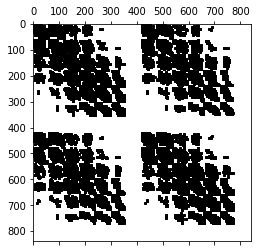

In [80]:
plt.spy(A, markersize=2, color='black')

In [57]:
nnz = rr.shape[0]

In [58]:
nnz

36410

In [60]:
N = rr[nnz - 1] + 1

In [61]:
N

771

In [64]:
range(771)

range(0, 771)

In [65]:
for ii in range(771):
    tid = rid[ii]
    print(tid)

325
127
322
256
662
741
535
575
84
489
215
247
6
270
165
242
210
400
167
772
402
530
175
550
570
320
109
131
357
32
443
217
444
839
312
748
315
272
685
40
37
619
206
467
26
541
820
689
88
43
245
532
184
418
85
673
224
659
564
459
583
295
514
16
71
465
700
498
451
783
144
220
832
381
678
834
617
802
306
789
580
488
496
211
58
553
838
763
249
336
73
115
287
116
589
55
403
809
434
390
356
69
797
123
538
221
401
701
95
235
269
752
650
706
104
232
389
10
635
790
60
609
21
698
739
545
629
516
79
652
722
766
833
544
125
423
57
59
54
341
285
243
595
309
732
100
30
78
633
34
198
424
372
364
571
174
658
141
252
9
388
743
720
86
308
132
428
680
120
229
93
194
64
645
162
350
836
588
581
622
830
426
674
339
155
351
552
453
611
587
477
837
268
452
497
379
68
468
798
284
92
479
394
48
593
151
607
136
665
529
383
735
427
108
568
725
82
472
769
150
534
338
368
765
344
196
258
696
41
709
562
726
458
331
397
711
391
448
818
405
3
182
640
302
157
107
187
228
542
436
195
181
511
233
416
250
758
683
126
382

In [7]:
G = nx.read_gml(train_network_path+"\\smwc11.gml")

In [12]:
s = 'smwc110.gml'

In [13]:
ssp = s.split('.')

In [15]:
ssp[0][4:]

'110'

In [8]:
adj_matrix = nx.adjacency_matrix(G)

In [9]:
adj_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.74191166, ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.74191166, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [22]:
nx.laplacian_matrix(G).todense()

matrix([[20.97192807,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , 19.45019811, -0.74191166, ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        , -0.74191166, 19.53625988, ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]])

In [24]:
np.sum(adj_matrix,axis = 0)

matrix([[ 20.97192807,  19.45019811,  19.53625988,  17.44347923,
          14.17520894,   0.        ,  21.41987745,  19.87360494,
          20.13104295,  22.78095131,  19.34466882,   0.        ,
           2.14850046,  -4.56021956,  -0.4655032 ,  13.99392615,
          20.91620592,  15.7234981 ,  -3.14889511,  -5.16701798,
           5.0730888 ,  22.95353469,  25.73021474,  16.8556703 ,
          17.91164462,  21.99680094,  21.49143039,  26.13609108,
          22.19986092,  16.08250088,  18.73666156,  14.52855899,
          13.12508812,  16.35743713,  19.73924313,  21.04496244,
          28.62717949,  28.7647989 ,  25.77536927,  30.16932357,
          25.9771357 ,  21.08420113,  14.46333352,  26.36050107,
          20.28726594,  23.41808646,  20.82244219,  18.28342532,
          13.72297298,  22.17562289,  20.07251755,  16.40189207,
           0.        ,   0.        ,  10.93386619,  18.90773406,
          16.80705111,   0.        ,   0.        ,   0.        ,
          27.00461457,  2

In [10]:
graph.laplacian(adj_matrix, normalized=True)

laplacian matrix
d shape (1, 840)


C:\Users\IITI\cnn_graph\lib\graph.py:134: RuntimeWarning: invalid value encountered in sqrt
  d = 1 / np.sqrt(d)


<840x840 sparse matrix of type '<class 'numpy.float64'>'
	with 55816 stored elements in Compressed Sparse Row format>

In [11]:
np.sqrt(0)

0.0

In [12]:
a = np.zeros([10])

In [15]:
a[0:5] = 1

In [17]:
o = np.ones([10])

In [16]:
1/np.sqrt(a)

C:\ProgramData\Anaconda3\envs\keras_dl\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.


array([ 1.,  1.,  1.,  1.,  1., inf, inf, inf, inf, inf])

In [20]:
np.divide(o,a,out = np.zeros_like(a),where=a != 0)

array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [28]:
for i,j,W in G.edges(data=True):
    if W['weight'] < 0:
        print(i,j,W)

0 6 {'weight': 0.5207759045981852}
0 7 {'weight': 0.33642380583715625}
0 26 {'weight': 0.43463026755054535}
0 30 {'weight': 0.33964872550219277}
0 60 {'weight': 0.9111566971364234}
0 61 {'weight': 0.368899172788218}
0 90 {'weight': 0.3116951327751727}
0 421 {'weight': 0.9705894629189368}
0 422 {'weight': 0.8786407723786166}
0 423 {'weight': 0.7405463638496514}
0 424 {'weight': 0.6284547139801014}
0 427 {'weight': 0.3446668592412393}
0 428 {'weight': 0.6070785158842437}
0 429 {'weight': 0.7390241753603002}
0 430 {'weight': 0.7263459013953799}
0 431 {'weight': 0.6107069991409445}
0 435 {'weight': 0.3311540201813014}
0 436 {'weight': 0.4572733981259005}
0 437 {'weight': 0.6165443819306987}
0 443 {'weight': 0.59283740821703}
0 446 {'weight': 0.5729648162045675}
0 447 {'weight': 0.7574473857296926}
0 448 {'weight': 0.6999818299333153}
0 449 {'weight': 0.37338300131209584}
0 481 {'weight': 0.7888724992607579}
0 482 {'weight': 0.9074097507348576}
0 483 {'weight': 0.8068430057314413}
0 484 {'w

12 627 {'weight': -0.32883194073817007}
12 630 {'weight': 0.7670869394516674}
12 636 {'weight': 0.6304179399467492}
12 637 {'weight': 0.4788203378625778}
12 639 {'weight': -0.3877335959968509}
12 644 {'weight': -0.46713954713428185}
12 645 {'weight': -0.3288902279170469}
12 648 {'weight': -0.5778939864801439}
12 649 {'weight': -0.44230299479746693}
12 672 {'weight': -0.5380323775437034}
12 674 {'weight': -0.37091655473906815}
12 678 {'weight': -0.3974621090007169}
12 680 {'weight': -0.5026811095931323}
12 681 {'weight': -0.42444034781634127}
12 686 {'weight': -0.6797793359500899}
12 687 {'weight': -0.44991503381236453}
12 692 {'weight': -0.5669338627378486}
12 693 {'weight': -0.4408228379926596}
12 696 {'weight': -0.6969742672490964}
12 697 {'weight': -0.5841097106164972}
12 698 {'weight': -0.5902470457451665}
12 702 {'weight': -0.559097681061214}
12 703 {'weight': -0.389745449200046}
12 738 {'weight': -0.35600013619809073}
12 744 {'weight': -0.49435160106393256}
12 745 {'weight': -0.3

17 69 {'weight': 0.46609882414902254}
17 70 {'weight': 0.7605702754907284}
17 71 {'weight': 0.8409929349891287}
17 76 {'weight': 0.4598299689840846}
17 77 {'weight': 0.7823340795777651}
17 83 {'weight': 0.5777619867409718}
17 420 {'weight': 0.5418546707508355}
17 480 {'weight': 0.339574502521075}
18 19 {'weight': 0.785402441146754}
18 20 {'weight': 0.6580236047767675}
18 24 {'weight': 0.469754843730078}
18 25 {'weight': 0.34471963546644424}
18 37 {'weight': 0.30335218612114156}
18 38 {'weight': 0.34275836785351976}
18 66 {'weight': -0.3976517337088954}
18 67 {'weight': -0.5102841961773387}
18 68 {'weight': -0.3999009170862859}
18 73 {'weight': 0.33238388823626525}
18 74 {'weight': -0.3870185227358454}
18 75 {'weight': -0.327527025100854}
18 78 {'weight': 0.34892695227521586}
18 79 {'weight': 0.6727844898879802}
18 80 {'weight': 0.431228801225893}
18 84 {'weight': 0.5267437098989175}
18 85 {'weight': 0.5424586687795796}
18 86 {'weight': 0.3305814659825183}
18 87 {'weight': 0.45717204719

21 148 {'weight': 0.3213556047499585}
21 152 {'weight': -0.3520831580940959}
21 154 {'weight': 0.39558995787677254}
21 156 {'weight': -0.3955300893422178}
21 160 {'weight': 0.7568408976994193}
21 161 {'weight': 0.5814130749407457}
21 164 {'weight': -0.4652447256254402}
21 165 {'weight': 0.36002278612732386}
21 166 {'weight': 0.6187869061098697}
21 167 {'weight': 0.5019343573922727}
21 170 {'weight': 0.38099854414285605}
21 186 {'weight': -0.3609504544394683}
21 187 {'weight': -0.3170676516759973}
21 192 {'weight': -0.6335327829805963}
21 204 {'weight': 0.44882617617277587}
21 205 {'weight': 0.583768683844786}
21 210 {'weight': 0.41102160335082777}
21 252 {'weight': -0.3691850564797695}
21 253 {'weight': -0.33381638211240267}
21 258 {'weight': -0.5768049445071345}
21 432 {'weight': 0.5004692942603005}
21 433 {'weight': 0.33840594841552346}
21 438 {'weight': 0.38807854688046317}
21 440 {'weight': 0.32495555240647384}
21 444 {'weight': 0.3524689399174271}
21 445 {'weight': 0.3178017336892

28 63 {'weight': 0.7491320942824211}
28 64 {'weight': 0.6713314752707948}
28 69 {'weight': 0.8083546685938162}
28 70 {'weight': 0.7956254282707075}
28 71 {'weight': 0.6739600182021523}
28 76 {'weight': 0.8123615425374996}
28 77 {'weight': 0.8123442697237938}
28 82 {'weight': 0.3845211589651721}
28 83 {'weight': 0.8542256511126752}
28 89 {'weight': 0.3133614291391663}
28 420 {'weight': 0.6562207248377946}
28 426 {'weight': 0.5289356465465332}
28 446 {'weight': 0.3136183502744495}
28 450 {'weight': 0.6121898713565925}
28 451 {'weight': 0.3516351062580815}
28 480 {'weight': 0.6093309530664928}
28 510 {'weight': 0.34991139851039255}
29 61 {'weight': 0.316661042883957}
29 62 {'weight': 0.6350948139690816}
29 63 {'weight': 0.6261889986804628}
29 64 {'weight': 0.6134378326958424}
29 69 {'weight': 0.6232948143139535}
29 70 {'weight': 0.6921930629665464}
29 71 {'weight': 0.6176015442304459}
29 76 {'weight': 0.6473782669663107}
29 77 {'weight': 0.7239067358575878}
29 83 {'weight': 0.755296040828

34 451 {'weight': 0.4925284514160868}
34 456 {'weight': 0.6580448297679041}
34 457 {'weight': 0.5931006746581362}
34 463 {'weight': 0.363802000647469}
34 523 {'weight': 0.32238125895461894}
34 524 {'weight': 0.31625596468568096}
34 560 {'weight': 0.32643865407607553}
34 614 {'weight': -0.30890603848799286}
34 619 {'weight': 0.48254588655732933}
34 621 {'weight': -0.4395505632400067}
34 633 {'weight': -0.33995008138073823}
34 679 {'weight': -0.33966047399291643}
34 686 {'weight': -0.3199640530625974}
34 691 {'weight': -0.3264391687067719}
35 38 {'weight': 0.33465519020450907}
35 39 {'weight': 0.5996950122346035}
35 40 {'weight': 0.8967092946456178}
35 41 {'weight': 0.8048694796266063}
35 42 {'weight': 0.5175378007788654}
35 45 {'weight': 0.6003804865410552}
35 46 {'weight': 0.6100836786241612}
35 47 {'weight': 0.5442848349959216}
35 49 {'weight': 0.8912025016411554}
35 50 {'weight': 0.9022532359788636}
35 51 {'weight': 0.5297947740027931}
35 55 {'weight': 0.5562808541392995}
35 56 {'wei

42 457 {'weight': 0.6047897546625357}
42 458 {'weight': 0.47334382036743655}
42 462 {'weight': 0.6067378583170374}
42 468 {'weight': 0.4411302457320685}
42 516 {'weight': 0.31372746167041504}
42 523 {'weight': 0.37050102830121634}
42 524 {'weight': 0.46930982021270484}
42 528 {'weight': 0.3613341967048529}
42 529 {'weight': 0.39640073283708177}
42 619 {'weight': 0.43577561589253594}
42 621 {'weight': -0.3410435887210693}
42 637 {'weight': 0.30159045843572924}
42 679 {'weight': -0.3677991338020669}
42 686 {'weight': -0.40007724836967057}
42 691 {'weight': -0.34561217345942224}
42 696 {'weight': -0.3202834680956674}
43 44 {'weight': 0.31062707552765967}
43 48 {'weight': 0.3406774370502666}
43 54 {'weight': 0.3856903989493352}
43 114 {'weight': 0.5926815730858566}
43 201 {'weight': -0.30354649593034977}
43 441 {'weight': 0.35064517499515}
43 442 {'weight': 0.5241129721286132}
43 445 {'weight': 0.3767364145604813}
43 454 {'weight': 0.41659027344786925}
43 455 {'weight': 0.4804743930268811}

66 631 {'weight': 0.4581539023894673}
66 633 {'weight': 0.42785472373356204}
66 636 {'weight': 0.38928713291048483}
66 648 {'weight': -0.5650563789229422}
66 649 {'weight': -0.40485043989239927}
66 667 {'weight': 0.41432319418444996}
66 668 {'weight': 0.3355917232866892}
66 673 {'weight': 0.5203092790023639}
66 674 {'weight': 0.49639852945207996}
66 675 {'weight': 0.48515940436723204}
66 681 {'weight': 0.38581091593816713}
66 682 {'weight': 0.3163864034526675}
66 685 {'weight': -0.3093478643257457}
66 687 {'weight': 0.3367375102023669}
66 702 {'weight': -0.3357479357421322}
67 68 {'weight': 0.7400028236618907}
67 73 {'weight': -0.7031071396600768}
67 75 {'weight': 0.6127502426968024}
67 80 {'weight': -0.5195263653830546}
67 97 {'weight': -0.38289850673439185}
67 98 {'weight': -0.6295061726505836}
67 99 {'weight': -0.5157205997772816}
67 108 {'weight': -0.30876828240238613}
67 120 {'weight': 0.4788449774882996}
67 121 {'weight': 0.5982088365554215}
67 122 {'weight': 0.3683757843120397}


74 96 {'weight': -0.32538297823224765}
74 97 {'weight': -0.5561991630177718}
74 108 {'weight': -0.39509775759530036}
74 127 {'weight': 0.37780422826035676}
74 128 {'weight': 0.3974722590982067}
74 134 {'weight': -0.4324666535838924}
74 135 {'weight': 0.6161973420996735}
74 138 {'weight': -0.3397908486971408}
74 139 {'weight': 0.3096057216581277}
74 140 {'weight': -0.40073265267832037}
74 141 {'weight': -0.34306030942930604}
74 142 {'weight': 0.49566779854181936}
74 148 {'weight': 0.45488548337484735}
74 152 {'weight': 0.5337672425194809}
74 158 {'weight': 0.3651277772231021}
74 162 {'weight': 0.4926388211968611}
74 174 {'weight': -0.4552789042886439}
74 187 {'weight': 0.40495127810602194}
74 192 {'weight': 0.3686250918343722}
74 195 {'weight': 0.5250754900813431}
74 200 {'weight': -0.6538461639373364}
74 202 {'weight': 0.3676428040507114}
74 206 {'weight': -0.3702717543177937}
74 207 {'weight': -0.44639007568539363}
74 208 {'weight': 0.46814344168607275}
74 212 {'weight': -0.3677662891

79 633 {'weight': -0.3188223283163715}
79 636 {'weight': 0.5811889560006284}
79 637 {'weight': 0.3298270262727081}
79 639 {'weight': -0.46094906095528004}
79 644 {'weight': -0.4266418472238945}
79 648 {'weight': -0.38237710508962497}
79 649 {'weight': -0.35836074044441646}
79 672 {'weight': -0.8131139658569254}
79 673 {'weight': -0.5915582177546693}
79 674 {'weight': -0.5204206084546971}
79 678 {'weight': -0.41017362463158646}
79 680 {'weight': -0.6561618157071456}
79 681 {'weight': -0.5061921245984741}
79 686 {'weight': -0.7834727633853149}
79 687 {'weight': -0.5664926000813607}
79 691 {'weight': -0.39848095883373263}
79 692 {'weight': -0.6669389281408872}
79 693 {'weight': -0.4726002550537382}
79 696 {'weight': -0.4534276906105546}
79 697 {'weight': -0.5802727718635206}
79 698 {'weight': -0.5871776741498227}
79 702 {'weight': -0.6680507996827357}
79 703 {'weight': -0.4159761934387007}
79 738 {'weight': -0.45938241470536345}
79 739 {'weight': -0.33086968948952633}
79 744 {'weight': -0

84 271 {'weight': -0.3185976842828879}
84 272 {'weight': -0.5000805045075596}
84 273 {'weight': -0.3299424798546601}
84 277 {'weight': -0.45856621191219576}
84 278 {'weight': -0.42915002220639825}
84 282 {'weight': -0.3328778188020191}
84 324 {'weight': -0.3045443316447479}
84 432 {'weight': 0.3715226489281232}
84 433 {'weight': 0.42019892937397346}
84 438 {'weight': 0.3994515710435944}
84 440 {'weight': 0.6273292241582764}
84 441 {'weight': 0.5028307212108178}
84 442 {'weight': 0.3269273556952378}
84 444 {'weight': 0.7851218880598396}
84 445 {'weight': 0.7501740669386462}
84 446 {'weight': 0.33409706356263846}
84 451 {'weight': 0.32849295096353925}
84 452 {'weight': 0.37153844892388227}
84 456 {'weight': 0.3905231403005546}
84 457 {'weight': 0.6242470788052008}
84 458 {'weight': 0.6214347988350992}
84 459 {'weight': 0.3955756115798463}
84 498 {'weight': 0.5449578446523259}
84 499 {'weight': 0.48066745859289195}
84 500 {'weight': 0.3067636086768341}
84 501 {'weight': 0.5041691141558922

88 102 {'weight': 0.7093168113535191}
88 103 {'weight': 0.7016041165094069}
88 104 {'weight': 0.6252267454666945}
88 105 {'weight': 0.6631267551171435}
88 108 {'weight': 0.3903744751087146}
88 109 {'weight': 0.5627154821692598}
88 110 {'weight': 0.4624545618863223}
88 134 {'weight': -0.5418214841314316}
88 138 {'weight': -0.46712058080552216}
88 139 {'weight': -0.3498036042533604}
88 140 {'weight': -0.527318250408064}
88 142 {'weight': 0.4620150804361357}
88 147 {'weight': -0.4618475925024123}
88 148 {'weight': 0.38105194758359584}
88 151 {'weight': -0.35801890581816104}
88 156 {'weight': -0.7181985955808969}
88 158 {'weight': -0.5015931359883856}
88 159 {'weight': 0.602685704721863}
88 160 {'weight': 0.4559756840726493}
88 186 {'weight': -0.31572242982994636}
88 192 {'weight': -0.3651923010828825}
88 198 {'weight': 0.4219164206524639}
88 201 {'weight': -0.356904223726794}
88 204 {'weight': 0.8294908757328658}
88 205 {'weight': 0.323602001075201}
88 207 {'weight': -0.47200452792807396}

92 148 {'weight': 0.37932026037098937}
92 149 {'weight': 0.4565327554795797}
92 154 {'weight': 0.5771698790578891}
92 171 {'weight': 0.3108888123615085}
92 200 {'weight': -0.43716577902955667}
92 202 {'weight': 0.42741028314727175}
92 208 {'weight': 0.5239668422749713}
92 209 {'weight': 0.3656164075023747}
92 211 {'weight': 0.40382951989360366}
92 214 {'weight': 0.5967932220506521}
92 215 {'weight': 0.3444055860821508}
92 216 {'weight': -0.49268904770026095}
92 218 {'weight': -0.47663527378262144}
92 219 {'weight': 0.5537859639407331}
92 220 {'weight': 0.4309815729875628}
92 223 {'weight': -0.6012640377921674}
92 225 {'weight': 0.5975448769488477}
92 229 {'weight': 0.5905089718151626}
92 230 {'weight': 0.4219437971269734}
92 253 {'weight': 0.3127891117083026}
92 254 {'weight': 0.3412985633246118}
92 260 {'weight': 0.4408476974512736}
92 261 {'weight': 0.535179661143454}
92 266 {'weight': 0.4945517038342817}
92 267 {'weight': 0.6124114328086211}
92 268 {'weight': 0.41704320541428724}
92

96 571 {'weight': -0.31111013539142307}
96 576 {'weight': -0.7668527965201335}
96 577 {'weight': -0.41886182387258203}
96 578 {'weight': -0.45741711130721413}
96 579 {'weight': 0.45517374152834206}
96 606 {'weight': -0.3179641108809964}
96 618 {'weight': 0.4351337593703561}
96 619 {'weight': 0.36073147703654573}
96 620 {'weight': 0.3363463333668418}
96 621 {'weight': -0.30343565915660375}
96 624 {'weight': 0.7286644642899751}
96 630 {'weight': 0.7080508567752466}
96 631 {'weight': -0.3839781507210828}
96 634 {'weight': -0.37279125466832835}
96 636 {'weight': 0.6399412733982044}
96 637 {'weight': 0.5791724364848607}
96 639 {'weight': -0.5758989749190087}
96 644 {'weight': -0.6016686047206196}
96 645 {'weight': -0.3625250330752581}
96 648 {'weight': -0.5691320683283393}
96 649 {'weight': -0.4748411637724458}
96 672 {'weight': -0.6146779400005955}
96 673 {'weight': -0.4519143463757668}
96 674 {'weight': -0.5142574536533742}
96 680 {'weight': -0.6792443435092934}
96 681 {'weight': -0.51520

102 159 {'weight': 0.6243085588565659}
102 186 {'weight': -0.45061220353666354}
102 187 {'weight': -0.47727315284409794}
102 188 {'weight': -0.3985536533102813}
102 192 {'weight': -0.4616175496466938}
102 195 {'weight': -0.3062691855618718}
102 200 {'weight': 0.5885300461355912}
102 201 {'weight': -0.4058147491359386}
102 202 {'weight': -0.3194186286417817}
102 204 {'weight': 0.7589128665832646}
102 207 {'weight': -0.3046598337614187}
102 210 {'weight': 0.7084197783178969}
102 211 {'weight': -0.5476865253931138}
102 214 {'weight': -0.36786288317559446}
102 218 {'weight': 0.47661231965080464}
102 219 {'weight': -0.3614985417365777}
102 225 {'weight': -0.3790839526054583}
102 228 {'weight': -0.3144945945203691}
102 229 {'weight': -0.4358268359577118}
102 230 {'weight': -0.3160677672423178}
102 252 {'weight': -0.5970522447160136}
102 253 {'weight': -0.5022423604962795}
102 254 {'weight': -0.606233387092016}
102 259 {'weight': 0.43974677526859035}
102 260 {'weight': -0.7541412014377291}
10

105 686 {'weight': -0.6406137196066662}
105 687 {'weight': -0.3112835751299435}
105 691 {'weight': -0.5530984982893566}
105 692 {'weight': -0.47214402458790417}
105 696 {'weight': -0.3887502935691021}
105 697 {'weight': -0.4565089275353396}
106 107 {'weight': 0.9037399142334863}
106 109 {'weight': 0.34300517432951455}
106 110 {'weight': 0.5768225924359217}
106 111 {'weight': 0.7760630412844124}
106 112 {'weight': 0.619459498762978}
106 113 {'weight': 0.4445539487138757}
106 115 {'weight': 0.4562352309458776}
106 116 {'weight': 0.46362310743799434}
106 117 {'weight': 0.5005616305395918}
106 118 {'weight': 0.44720752529984975}
106 160 {'weight': 0.4827269102152169}
106 161 {'weight': 0.6329951673484923}
106 166 {'weight': 0.3414065571844339}
106 167 {'weight': 0.30664529372699856}
106 192 {'weight': -0.3533539910679131}
106 205 {'weight': 0.44651190347659536}
106 258 {'weight': -0.34784809558718943}
106 451 {'weight': 0.3300764894134473}
106 456 {'weight': 0.8510244596302888}
106 457 {'w

120 188 {'weight': 0.37995340161604585}
120 212 {'weight': 0.5406099912996661}
120 219 {'weight': -0.3223421877319096}
120 224 {'weight': -0.42629293633814913}
120 228 {'weight': -0.32343863410142293}
120 252 {'weight': 0.41552664426918506}
120 427 {'weight': 0.44521382180120805}
120 428 {'weight': 0.49367420479719254}
120 435 {'weight': 0.3867026124437183}
120 438 {'weight': -0.305254972362817}
120 487 {'weight': 0.5475076751519409}
120 488 {'weight': 0.6693474363430781}
120 489 {'weight': 0.35653384244138614}
120 495 {'weight': 0.3941715068574451}
120 496 {'weight': 0.36909013460046186}
120 508 {'weight': 0.30410958987025005}
120 511 {'weight': -0.4450216329980075}
120 540 {'weight': 0.6682397736247281}
120 541 {'weight': 0.9070541540878551}
120 542 {'weight': 0.6370714120172651}
120 543 {'weight': 0.45400173304138935}
120 544 {'weight': 0.4057146831491867}
120 547 {'weight': -0.3805639563521063}
120 548 {'weight': 0.35697481095093225}
120 549 {'weight': 0.7908484415847753}
120 550 {

129 200 {'weight': -0.327393629287469}
129 202 {'weight': 0.6852444701943958}
129 203 {'weight': 0.5648271840786887}
129 207 {'weight': -0.34873946221387875}
129 208 {'weight': 0.33078248202348215}
129 222 {'weight': -0.3509705656528258}
129 247 {'weight': 0.30426724858264054}
129 253 {'weight': 0.45663537585554026}
129 255 {'weight': 0.44914374782189065}
129 262 {'weight': 0.3477995776021724}
129 426 {'weight': 0.3670094379287921}
129 440 {'weight': -0.3205656254985087}
129 486 {'weight': 0.6190235941635138}
129 487 {'weight': 0.3299147967383494}
129 492 {'weight': -0.3464591773283538}
129 500 {'weight': -0.30870256165864257}
129 505 {'weight': 0.31132999879732964}
129 513 {'weight': -0.31622139986923387}
129 518 {'weight': -0.37328276345037803}
129 519 {'weight': -0.3289588949545889}
129 540 {'weight': 0.7320111173844585}
129 548 {'weight': 0.32164892725004335}
129 552 {'weight': 0.33113112752283674}
129 568 {'weight': -0.41045466986216417}
129 570 {'weight': 0.4537622287130651}
129 

136 203 {'weight': 0.6070041021632285}
136 206 {'weight': -0.30723812590782945}
136 207 {'weight': -0.367366806598248}
136 208 {'weight': 0.3704571752374783}
136 222 {'weight': -0.41256446847972167}
136 253 {'weight': 0.43243658319834494}
136 255 {'weight': 0.4550341125863695}
136 262 {'weight': 0.365117645212613}
136 426 {'weight': 0.3514829959987582}
136 440 {'weight': -0.31658368133609255}
136 486 {'weight': 0.6031737882008843}
136 492 {'weight': -0.3307081678769477}
136 500 {'weight': -0.3163793870947773}
136 505 {'weight': 0.3049872390830964}
136 513 {'weight': -0.32664946826019703}
136 518 {'weight': -0.34873254971145473}
136 519 {'weight': -0.33199557528147716}
136 540 {'weight': 0.6330416126750026}
136 546 {'weight': -0.3193878684971363}
136 552 {'weight': 0.3111983505462202}
136 562 {'weight': -0.3177346258912045}
136 568 {'weight': -0.4361638369805951}
136 570 {'weight': 0.4064768438817749}
136 571 {'weight': 0.41605437677726326}
136 572 {'weight': -0.3162241734711463}
136 57

141 614 {'weight': -0.3009579097202217}
141 618 {'weight': 0.7517603553936831}
141 622 {'weight': 0.32528322126374587}
141 624 {'weight': 0.4739582726223811}
141 627 {'weight': -0.4366894620397474}
141 628 {'weight': 0.4336570680791824}
141 632 {'weight': -0.4703945706079173}
141 634 {'weight': 0.41132392618124797}
141 639 {'weight': 0.4169071270484169}
141 645 {'weight': 0.34285122305659244}
141 649 {'weight': 0.3822000043657292}
141 666 {'weight': -0.3408680309504253}
141 672 {'weight': -0.39125618939613244}
141 684 {'weight': 0.4298492790177685}
141 703 {'weight': 0.31741578528150566}
141 738 {'weight': -0.3264069524715985}
142 143 {'weight': 0.41434214465599684}
142 147 {'weight': -0.48018179747642514}
142 148 {'weight': 0.645689924571745}
142 149 {'weight': 0.5202768134834697}
142 152 {'weight': 0.4278906828449891}
142 153 {'weight': -0.39120663126624206}
142 154 {'weight': 0.5470035781569145}
142 156 {'weight': -0.31140034384085846}
142 162 {'weight': 0.31727652513881704}
142 165

148 214 {'weight': 0.6534081616468005}
148 218 {'weight': -0.4936240853264718}
148 219 {'weight': 0.7307520277542547}
148 220 {'weight': 0.35967520473874176}
148 224 {'weight': 0.47438741225396136}
148 225 {'weight': 0.5114991394906938}
148 229 {'weight': 0.30130697050877514}
148 253 {'weight': 0.33846028922183985}
148 260 {'weight': 0.3152803284579667}
148 264 {'weight': 0.42283508950017595}
148 266 {'weight': 0.3113629775888407}
148 267 {'weight': 0.3043617447271797}
148 273 {'weight': 0.39707940886940757}
148 278 {'weight': 0.3734019393187389}
148 428 {'weight': -0.32978254127038165}
148 434 {'weight': -0.3864667933541855}
148 435 {'weight': -0.4708037358864232}
148 441 {'weight': -0.41228325524212994}
148 446 {'weight': -0.31148715219943446}
148 453 {'weight': -0.3848368412666396}
148 487 {'weight': -0.3049887619094525}
148 488 {'weight': -0.5392959331659083}
148 489 {'weight': -0.3149466719355986}
148 494 {'weight': -0.3417090532417226}
148 495 {'weight': -0.744799606662749}
148 4

154 209 {'weight': 0.4460476267883307}
154 212 {'weight': -0.5061168857141085}
154 213 {'weight': -0.34567357731274895}
154 214 {'weight': 0.7887888186787326}
154 215 {'weight': 0.40695392512405576}
154 218 {'weight': -0.5691913616253802}
154 219 {'weight': 0.6604902694902632}
154 220 {'weight': 0.5606615995939946}
154 223 {'weight': -0.3760165254459831}
154 224 {'weight': 0.3726887660272131}
154 225 {'weight': 0.7220771280517003}
154 229 {'weight': 0.47211801915742524}
154 230 {'weight': 0.4545458404325941}
154 252 {'weight': -0.4236904521771971}
154 258 {'weight': -0.31788779466507566}
154 261 {'weight': 0.3544445823914034}
154 267 {'weight': 0.33182982118038007}
154 268 {'weight': 0.41380519078261707}
154 270 {'weight': -0.41942675193639833}
154 273 {'weight': 0.5167314687940077}
154 274 {'weight': 0.35898899674629015}
154 278 {'weight': 0.4813383179088173}
154 279 {'weight': 0.44957112184711046}
154 283 {'weight': 0.35072378519921515}
154 284 {'weight': 0.37107171825839724}
154 325

159 546 {'weight': -0.5241029309791051}
159 548 {'weight': -0.38823273741452297}
159 549 {'weight': -0.3778014954621822}
159 553 {'weight': -0.6412577464957261}
159 555 {'weight': -0.48329669728585894}
159 556 {'weight': -0.43676364436372017}
159 559 {'weight': -0.5934644577628188}
159 561 {'weight': 0.6396204212145112}
159 562 {'weight': -0.6207131683947754}
159 563 {'weight': -0.4526463373180196}
159 564 {'weight': 0.32715543321493146}
159 568 {'weight': -0.4960531707101897}
159 569 {'weight': -0.4474932780230218}
159 572 {'weight': -0.44292419822524925}
159 574 {'weight': -0.44054205337194485}
159 588 {'weight': 0.3343729782447284}
159 606 {'weight': -0.5009142489445899}
159 607 {'weight': -0.402606080240706}
159 608 {'weight': -0.4559495185575627}
159 609 {'weight': -0.34546772880149995}
159 615 {'weight': -0.6951101890295259}
159 616 {'weight': -0.387336730765109}
159 619 {'weight': 0.3211353286828875}
159 620 {'weight': 0.49723953740317106}
159 622 {'weight': -0.71562635862354}
1

168 440 {'weight': 0.42569272413482184}
168 444 {'weight': 0.358092807531087}
168 480 {'weight': -0.31865669192210266}
168 486 {'weight': -0.6666505791157082}
168 487 {'weight': -0.6360974234295195}
168 488 {'weight': -0.49315780982990665}
168 500 {'weight': 0.3820285920869616}
168 507 {'weight': -0.33354231325978434}
168 510 {'weight': -0.3264456012630869}
168 514 {'weight': 0.34279212900441525}
168 518 {'weight': 0.4206950428237755}
168 519 {'weight': 0.5462724326440018}
168 528 {'weight': 0.34289594232633347}
168 529 {'weight': 0.32231239274112133}
168 540 {'weight': -0.6908311065552101}
168 541 {'weight': -0.5519342186819038}
168 548 {'weight': -0.4516797391063619}
168 549 {'weight': -0.3649888815771221}
168 555 {'weight': -0.30244850396495476}
168 558 {'weight': 0.48561316471058624}
168 566 {'weight': -0.5939295585947578}
168 568 {'weight': 0.3868647331058611}
168 570 {'weight': -0.3412934020092365}
168 571 {'weight': -0.5647343891752957}
168 572 {'weight': 0.3444213101457853}
168

181 261 {'weight': 0.3100377533448682}
181 262 {'weight': 0.6728073558363656}
181 263 {'weight': 0.5416878542020261}
181 272 {'weight': 0.3233331901278591}
181 273 {'weight': 0.3125606149164083}
181 307 {'weight': 0.7796013075086855}
181 308 {'weight': 0.5451897073767409}
181 309 {'weight': 0.414533004978653}
181 310 {'weight': 0.3525690620682115}
181 312 {'weight': 0.41952869386055486}
181 313 {'weight': 0.9175144570708235}
181 314 {'weight': 0.7270777497313397}
181 315 {'weight': 0.5360091215673781}
181 316 {'weight': 0.43687156433957447}
181 318 {'weight': 0.3597007871309619}
181 319 {'weight': 0.3997558412587743}
181 320 {'weight': 0.3060537158339742}
181 321 {'weight': 0.38987946540064794}
181 322 {'weight': 0.4214344667825628}
181 325 {'weight': 0.31372313030822085}
181 326 {'weight': 0.38984402085602937}
181 486 {'weight': 0.3520387666003305}
181 493 {'weight': -0.32919089453557415}
181 500 {'weight': -0.3978917306949861}
181 513 {'weight': -0.3334889962544864}
181 540 {'weight'

189 486 {'weight': 0.48319744789938274}
189 492 {'weight': -0.3931771917324459}
189 500 {'weight': -0.4271992370770724}
189 513 {'weight': -0.41574908278554706}
189 518 {'weight': -0.34102981402772614}
189 540 {'weight': 0.49777988880827984}
189 552 {'weight': 0.3035360083443761}
189 570 {'weight': 0.3844681345580774}
189 600 {'weight': 0.6046480150309074}
189 607 {'weight': 0.41784665490107586}
189 613 {'weight': -0.4333274699561427}
189 618 {'weight': -0.38444428256864}
189 632 {'weight': 0.3294445812850692}
189 660 {'weight': 0.4202307657519074}
189 666 {'weight': 0.6888520048338791}
189 726 {'weight': 0.3774829225852211}
189 732 {'weight': 0.5779306359941274}
189 738 {'weight': 0.36474428598225295}
190 191 {'weight': 0.9444054385991606}
190 196 {'weight': 0.7088974036268859}
190 197 {'weight': 0.9793234732654199}
190 203 {'weight': 0.7880200238775961}
190 241 {'weight': 0.6180205359736218}
190 242 {'weight': 0.7596481794667529}
190 243 {'weight': 0.710227585535341}
190 244 {'weight

198 629 {'weight': -0.3141203171333988}
198 631 {'weight': -0.4600232169673982}
198 637 {'weight': 0.3931536388663159}
198 638 {'weight': 0.31008983063702916}
198 639 {'weight': -0.3763869135754373}
198 644 {'weight': -0.32760455490871193}
198 648 {'weight': 0.36118842043622074}
198 650 {'weight': 0.33049281852200285}
198 666 {'weight': -0.3466568860802426}
198 667 {'weight': -0.4218284060005117}
198 673 {'weight': -0.5576354853866613}
198 674 {'weight': -0.6265296745639057}
198 675 {'weight': -0.46780147617202883}
198 680 {'weight': -0.48377446722751083}
198 681 {'weight': -0.48531605489642593}
198 682 {'weight': -0.3306424430844623}
198 684 {'weight': -0.31060363278791886}
198 685 {'weight': 0.3626402459529619}
198 687 {'weight': -0.5222730529593252}
198 691 {'weight': -0.33588908480743296}
198 692 {'weight': -0.5080084243669037}
198 697 {'weight': -0.3632346762049947}
198 739 {'weight': -0.36019493154843457}
199 201 {'weight': -0.3633303394662954}
199 213 {'weight': -0.3209699912963

204 330 {'weight': -0.408668042405644}
204 426 {'weight': 0.34606526144138744}
204 427 {'weight': 0.3022137974495195}
204 432 {'weight': 0.8321857790526271}
204 433 {'weight': 0.6692457128819403}
204 434 {'weight': 0.40831811180155975}
204 438 {'weight': 0.7005472363201313}
204 439 {'weight': 0.5812479841231813}
204 440 {'weight': 0.4399816802858956}
204 444 {'weight': 0.37433187783349725}
204 445 {'weight': 0.42009307034311594}
204 451 {'weight': 0.5464688738267598}
204 452 {'weight': 0.565636669092211}
204 453 {'weight': 0.3581616723591638}
204 457 {'weight': 0.3714433632587224}
204 458 {'weight': 0.40200658193339284}
204 494 {'weight': -0.4391950462967304}
204 498 {'weight': 0.5772222146449721}
204 499 {'weight': 0.8928519815755009}
204 500 {'weight': 0.4137730985120455}
204 501 {'weight': 0.5902257804335022}
204 504 {'weight': 0.642065521114082}
204 505 {'weight': 0.8088185349973354}
204 507 {'weight': 0.4966716391924905}
204 510 {'weight': 0.6825493637450263}
204 511 {'weight': 0.

210 619 {'weight': 0.4729055375634441}
210 620 {'weight': 0.40860578568727324}
210 621 {'weight': -0.41759725521666735}
210 622 {'weight': -0.34724869831734545}
210 624 {'weight': 0.4129478248981013}
210 628 {'weight': -0.48149833877142295}
210 630 {'weight': 0.36918564060041364}
210 632 {'weight': 0.4840537506340543}
210 633 {'weight': -0.3051596996673778}
210 634 {'weight': -0.4298654027792982}
210 636 {'weight': 0.4284697171855196}
210 637 {'weight': 0.6503210935934095}
210 639 {'weight': -0.7187177182566062}
210 644 {'weight': -0.7161249593252521}
210 645 {'weight': -0.3321584962363871}
210 648 {'weight': -0.42751369177859955}
210 649 {'weight': -0.44891083264835835}
210 672 {'weight': -0.4699437542968516}
210 673 {'weight': -0.45687581378447456}
210 674 {'weight': -0.39772893352883626}
210 680 {'weight': -0.7739394043857792}
210 681 {'weight': -0.3654315868855556}
210 684 {'weight': -0.4806927565406938}
210 686 {'weight': -0.7880969857378599}
210 687 {'weight': -0.5836725481732229

217 644 {'weight': -0.35679042445305076}
217 680 {'weight': -0.39989709952378166}
217 686 {'weight': -0.34810365690746736}
217 692 {'weight': -0.4187294614532753}
217 696 {'weight': -0.677770094970125}
217 697 {'weight': -0.3648602583355211}
218 219 {'weight': -0.6786273923957278}
218 220 {'weight': -0.5256415823466605}
218 223 {'weight': 0.336395485531589}
218 224 {'weight': -0.4797508088087977}
218 225 {'weight': -0.6830315286692136}
218 229 {'weight': -0.3991743724975826}
218 230 {'weight': -0.43203606668717687}
218 253 {'weight': -0.4656728398597192}
218 254 {'weight': -0.47461223979385564}
218 255 {'weight': -0.45091088240605676}
218 260 {'weight': -0.5015696244298973}
218 261 {'weight': -0.7772574222728101}
218 262 {'weight': -0.4016791176844114}
218 266 {'weight': -0.5047352448750343}
218 267 {'weight': -0.7029936290871853}
218 268 {'weight': -0.543612836053297}
218 272 {'weight': -0.6063699664683692}
218 273 {'weight': -0.777092658508634}
218 274 {'weight': -0.4265562630085402}

225 452 {'weight': -0.33007796308212134}
225 487 {'weight': -0.5242179511345192}
225 488 {'weight': -0.37050392176226576}
225 493 {'weight': 0.3027214194663733}
225 494 {'weight': -0.5405097341672499}
225 495 {'weight': -0.4364361688099138}
225 498 {'weight': -0.3480250223767399}
225 501 {'weight': -0.5617685493900282}
225 505 {'weight': -0.31931032090038863}
225 506 {'weight': -0.4955616049413846}
225 507 {'weight': -0.49999680674674124}
225 508 {'weight': -0.44373722569628965}
225 513 {'weight': -0.30879632817061964}
225 514 {'weight': -0.33076553958961086}
225 516 {'weight': -0.4428342080880891}
225 518 {'weight': 0.3383117064935341}
225 522 {'weight': -0.43679652314441186}
225 523 {'weight': -0.3762539278691527}
225 524 {'weight': -0.3105740742813609}
225 548 {'weight': -0.5082735174655281}
225 554 {'weight': 0.5974191171088683}
225 555 {'weight': -0.6253173173987192}
225 558 {'weight': 0.5522534616737079}
225 560 {'weight': 0.45268594571879356}
225 561 {'weight': 0.459443544301678

232 344 {'weight': 0.7696982350142179}
232 345 {'weight': 0.7312407342205997}
232 346 {'weight': 0.6824304279113866}
232 349 {'weight': 0.665605455673925}
232 350 {'weight': 0.6861977504217952}
233 235 {'weight': 0.5936999595253856}
233 236 {'weight': 0.900152149994032}
233 237 {'weight': 0.9560179858166122}
233 238 {'weight': 0.9939455101474517}
233 274 {'weight': 0.42018184610493603}
233 275 {'weight': 0.8069384111064899}
233 280 {'weight': 0.7890941229603318}
233 281 {'weight': 0.8887701178496071}
233 285 {'weight': 0.7065030338391657}
233 286 {'weight': 0.9095230397433444}
233 287 {'weight': 0.9200485879008089}
233 289 {'weight': 0.6018284419020254}
233 290 {'weight': 0.8519298644836251}
233 291 {'weight': 0.9385872396796183}
233 292 {'weight': 0.9650701784961228}
233 295 {'weight': 0.8661349080326458}
233 296 {'weight': 0.9000988575431007}
233 297 {'weight': 0.9508887962789874}
233 332 {'weight': 0.49872355180672695}
233 333 {'weight': 0.6139528247543168}
233 334 {'weight': 0.8417

247 660 {'weight': 0.6404696101158541}
247 666 {'weight': 0.9811786199428222}
247 667 {'weight': 0.670373676741198}
247 668 {'weight': 0.3928299706545433}
247 673 {'weight': 0.31541415331157624}
247 674 {'weight': 0.44048638731616013}
247 675 {'weight': 0.3869270715643925}
247 681 {'weight': 0.38594959072169577}
247 726 {'weight': 0.6251349946390831}
247 732 {'weight': 0.8294454493989212}
247 733 {'weight': 0.5079894547098701}
247 738 {'weight': 0.6314281662098051}
247 744 {'weight': 0.48169270386831237}
248 249 {'weight': 0.7571853862494892}
248 250 {'weight': 0.5772069164384849}
248 251 {'weight': 0.4644384076351592}
248 254 {'weight': 0.3546773981998199}
248 255 {'weight': 0.7429706978907255}
248 256 {'weight': 0.7492167154011535}
248 257 {'weight': 0.5872835756079796}
248 262 {'weight': 0.7202740274110727}
248 263 {'weight': 0.6361147775637555}
248 273 {'weight': 0.3222456990684655}
248 307 {'weight': 0.8112882237659806}
248 308 {'weight': 0.5980600202213178}
248 309 {'weight': 0.4

256 660 {'weight': 0.5338593142736033}
256 666 {'weight': 0.5402958872814334}
256 726 {'weight': 0.4893555410890307}
256 732 {'weight': 0.6691201059678475}
257 262 {'weight': 0.5609763933814846}
257 263 {'weight': 0.8878222613752544}
257 307 {'weight': 0.6468034004195441}
257 308 {'weight': 0.926744957343093}
257 309 {'weight': 0.948590396197424}
257 310 {'weight': 0.8764237261625802}
257 313 {'weight': 0.40982771463298323}
257 314 {'weight': 0.9084735829185479}
257 315 {'weight': 0.9822991559960761}
257 316 {'weight': 0.9380572023420943}
257 321 {'weight': 0.5485998407964946}
257 322 {'weight': 0.8064420054707366}
257 328 {'weight': 0.3564701153045803}
257 600 {'weight': 0.32179764371598685}
257 660 {'weight': 0.4988588048355892}
257 666 {'weight': 0.36472962666500697}
257 726 {'weight': 0.44355262842474474}
257 732 {'weight': 0.48086055429262525}
258 264 {'weight': 0.32700016736331355}
258 266 {'weight': 0.31716367213598917}
258 270 {'weight': 0.48175068934512727}
258 276 {'weight': 

266 277 {'weight': 0.7734357020830837}
266 278 {'weight': 0.8121054369694516}
266 279 {'weight': 0.38011153303797096}
266 282 {'weight': 0.7757526808897833}
266 283 {'weight': 0.682392438701929}
266 284 {'weight': 0.39948138744659134}
266 288 {'weight': 0.32694587147275744}
266 318 {'weight': 0.3313509847232637}
266 319 {'weight': 0.3315195037064303}
266 324 {'weight': 0.7066377463096254}
266 325 {'weight': 0.48749532843717125}
266 330 {'weight': 0.5794117820474034}
266 331 {'weight': 0.37076657831953025}
266 336 {'weight': 0.3558892486140898}
266 426 {'weight': -0.3328121347138863}
266 427 {'weight': -0.4423891956436064}
266 428 {'weight': -0.30881461332035826}
266 432 {'weight': -0.6855759008960611}
266 433 {'weight': -0.7246538750976966}
266 434 {'weight': -0.7659950758475708}
266 435 {'weight': -0.41749682939244437}
266 438 {'weight': -0.3698506451933273}
266 439 {'weight': -0.442154425815632}
266 440 {'weight': -0.6300845632043545}
266 441 {'weight': -0.4634128810044005}
266 444 {

273 336 {'weight': 0.3145650978678632}
273 432 {'weight': -0.518211711869364}
273 433 {'weight': -0.7019879270411392}
273 434 {'weight': -0.6084984541720497}
273 438 {'weight': -0.45267368942004815}
273 439 {'weight': -0.5385135897140714}
273 440 {'weight': -0.5239722498947454}
273 444 {'weight': -0.3138034817870198}
273 451 {'weight': -0.32859141214448256}
273 452 {'weight': -0.3845912437809418}
273 488 {'weight': -0.3547481186969247}
273 495 {'weight': -0.4091573644966898}
273 498 {'weight': -0.43618364525626396}
273 499 {'weight': -0.5124985095408257}
273 500 {'weight': -0.3844723753521059}
273 501 {'weight': -0.6754764784097627}
273 502 {'weight': -0.3206523203082501}
273 504 {'weight': -0.3245879606017451}
273 505 {'weight': -0.534022160807332}
273 506 {'weight': -0.6249996117682809}
273 507 {'weight': -0.6739307952384189}
273 508 {'weight': -0.5042278576908497}
273 512 {'weight': 0.3870422439530475}
273 513 {'weight': -0.47266839065455907}
273 514 {'weight': -0.3915393413146838}


280 343 {'weight': 0.6857248009055169}
280 344 {'weight': 0.8639016857740592}
280 345 {'weight': 0.7930431147051765}
280 346 {'weight': 0.7002638694582191}
280 349 {'weight': 0.7436648485988704}
280 350 {'weight': 0.7068564552384625}
280 654 {'weight': 0.352786848336212}
280 750 {'weight': 0.3103751317738206}
280 756 {'weight': 0.4320026570054064}
281 284 {'weight': 0.42684612467172955}
281 285 {'weight': 0.8614126276945582}
281 286 {'weight': 0.9856695176146597}
281 287 {'weight': 0.9398518847448057}
281 289 {'weight': 0.6721448882662417}
281 290 {'weight': 0.8860975091204288}
281 291 {'weight': 0.9297911307196898}
281 292 {'weight': 0.9109859450358235}
281 295 {'weight': 0.8110086415352331}
281 296 {'weight': 0.8197060303346954}
281 297 {'weight': 0.8371678913084502}
281 331 {'weight': 0.37757371567368475}
281 332 {'weight': 0.6939830432037163}
281 333 {'weight': 0.8568378204205939}
281 334 {'weight': 0.9743196881138684}
281 337 {'weight': 0.6828365328781181}
281 338 {'weight': 0.927

294 650 {'weight': 0.3881947736065226}
294 654 {'weight': 0.6894624231496876}
294 655 {'weight': 0.6111999487379092}
294 656 {'weight': 0.37743475332829857}
294 657 {'weight': 0.32043427892890136}
294 704 {'weight': 0.44471244145597016}
294 705 {'weight': 0.3981546514292755}
294 708 {'weight': 0.7827511061906389}
294 709 {'weight': 0.6007326956808042}
294 710 {'weight': 0.5051385837574831}
294 711 {'weight': 0.3114387846075747}
294 714 {'weight': 0.9569312863256446}
294 715 {'weight': 0.39951244934620506}
294 716 {'weight': 0.31919504944154065}
294 750 {'weight': 0.3159146718151492}
294 752 {'weight': 0.5264472916237167}
294 753 {'weight': 0.326959968066731}
294 756 {'weight': 0.6752255366062729}
294 757 {'weight': 0.4855132675912042}
294 758 {'weight': 0.5214818682848024}
294 762 {'weight': 0.9516551604677249}
294 763 {'weight': 0.714730583055949}
294 764 {'weight': 0.3096021082853769}
294 768 {'weight': 0.9576356261820035}
294 769 {'weight': 0.35680122162971567}
295 296 {'weight': 0.

324 638 {'weight': -0.4690175836107094}
324 639 {'weight': 0.5869472549357907}
324 640 {'weight': 0.36343262408811644}
324 643 {'weight': -0.33270204998551994}
324 644 {'weight': 0.37384604719493875}
324 645 {'weight': 0.5071133922567231}
324 648 {'weight': 0.4011111414997625}
324 649 {'weight': 0.6391791179356554}
324 650 {'weight': 0.5740692895472107}
324 654 {'weight': 0.4256796627948246}
324 655 {'weight': 0.3071128950501873}
324 672 {'weight': 0.4330460662413515}
324 673 {'weight': 0.353915515745211}
324 674 {'weight': 0.6132355845435319}
324 675 {'weight': 0.3377021873694561}
324 678 {'weight': 0.33044593089757546}
324 680 {'weight': 0.4620355099692116}
324 681 {'weight': 0.7279883979820768}
324 684 {'weight': 0.44260111575592237}
324 685 {'weight': -0.4339303419118589}
324 686 {'weight': 0.5620644142850589}
324 687 {'weight': 0.7156561206315042}
324 688 {'weight': 0.4776898730395048}
324 692 {'weight': 0.47908673724978956}
324 693 {'weight': 0.7756922198464294}
324 694 {'weight'

420 480 {'weight': 0.8135025217086547}
420 481 {'weight': 0.3485674116160845}
420 510 {'weight': 0.35344602241308176}
421 422 {'weight': 0.7698471460289142}
421 423 {'weight': 0.6167575463947}
421 424 {'weight': 0.5013667791839581}
421 427 {'weight': 0.41711747206278366}
421 428 {'weight': 0.6289356805761713}
421 429 {'weight': 0.6588936070362197}
421 430 {'weight': 0.5977619663922153}
421 431 {'weight': 0.4862507391497843}
421 435 {'weight': 0.32619998615901036}
421 436 {'weight': 0.38293052229428776}
421 437 {'weight': 0.49375335470003284}
421 443 {'weight': 0.4785574555652226}
421 446 {'weight': 0.6575285160826262}
421 447 {'weight': 0.8244772587242893}
421 448 {'weight': 0.6129132673890451}
421 449 {'weight': 0.3014593566885481}
421 480 {'weight': 0.43241044688912744}
421 481 {'weight': 0.8620184276029453}
421 482 {'weight': 0.8384039653367669}
421 483 {'weight': 0.6852773015400734}
421 484 {'weight': 0.5702828685644997}
421 489 {'weight': 0.6169023415330701}
421 490 {'weight': 0.6

432 577 {'weight': -0.5420128741893924}
432 578 {'weight': -0.5620974412889541}
432 585 {'weight': -0.47587956813736204}
432 590 {'weight': -0.3744328172473826}
432 615 {'weight': -0.4164248825579897}
432 619 {'weight': 0.5716514583664936}
432 620 {'weight': 0.4282744473844188}
432 621 {'weight': -0.44794570712006276}
432 622 {'weight': -0.41804793702769677}
432 624 {'weight': 0.4276341132847019}
432 628 {'weight': -0.542067751969049}
432 630 {'weight': 0.4040785913438524}
432 631 {'weight': -0.3395995465630775}
432 632 {'weight': 0.5089705523788148}
432 633 {'weight': -0.31796719955170183}
432 634 {'weight': -0.5445323134447453}
432 636 {'weight': 0.3448970451599443}
432 637 {'weight': 0.6478330541428658}
432 638 {'weight': 0.3103719890966766}
432 639 {'weight': -0.7801622847220491}
432 644 {'weight': -0.8356207690352784}
432 645 {'weight': -0.4325274098663013}
432 648 {'weight': -0.5114577966585754}
432 649 {'weight': -0.5130753703113906}
432 672 {'weight': -0.5103340438773429}
432 6

441 524 {'weight': 0.5108912674737079}
441 525 {'weight': 0.821336993969553}
441 526 {'weight': 0.6095832759971006}
441 527 {'weight': 0.35212841254698374}
441 528 {'weight': 0.4038384929388936}
441 529 {'weight': 0.7242750224804354}
441 530 {'weight': 0.667323813591753}
441 531 {'weight': 0.5181316253845688}
441 532 {'weight': 0.30920480555747576}
441 535 {'weight': 0.3755434007544441}
441 536 {'weight': 0.32113063612073695}
441 546 {'weight': -0.34169467949837085}
441 564 {'weight': -0.30418269047661456}
441 571 {'weight': -0.3669773220202268}
441 574 {'weight': 0.4667440856722582}
441 576 {'weight': -0.3641203939405613}
441 579 {'weight': 0.3828401126530529}
441 580 {'weight': 0.5910724093172042}
441 581 {'weight': 0.4424692912848089}
441 584 {'weight': -0.3602597244649111}
441 585 {'weight': 0.363492311899537}
441 586 {'weight': 0.6032803661052126}
441 587 {'weight': 0.527053567913632}
441 590 {'weight': 0.3354314403156748}
441 606 {'weight': -0.39864691887597803}
441 607 {'weight'

454 538 {'weight': 0.3160051805216498}
454 580 {'weight': 0.42747246771937836}
454 581 {'weight': 0.41937694348752885}
454 625 {'weight': 0.353987620441645}
454 678 {'weight': -0.3824149265946218}
455 458 {'weight': 0.3560862811546576}
455 459 {'weight': 0.6255061337791367}
455 460 {'weight': 0.7555790034372037}
455 461 {'weight': 0.6861652610173665}
455 462 {'weight': 0.48942217695699086}
455 465 {'weight': 0.5677068186344786}
455 466 {'weight': 0.5885643529102254}
455 467 {'weight': 0.5305907190170224}
455 469 {'weight': 0.8236104299690337}
455 470 {'weight': 0.7995864519011059}
455 471 {'weight': 0.48032015094507596}
455 475 {'weight': 0.5152749762129548}
455 476 {'weight': 0.5319072067953211}
455 509 {'weight': 0.4737689366983079}
455 515 {'weight': 0.44467751396969235}
455 520 {'weight': 0.4579004537051718}
455 521 {'weight': 0.41950453361965107}
455 525 {'weight': 0.44745251798127195}
455 526 {'weight': 0.8806100017390599}
455 527 {'weight': 0.9337320505707077}
455 530 {'weight':

486 607 {'weight': 0.5112885447118274}
486 608 {'weight': 0.37376392633126854}
486 613 {'weight': -0.35881095992623124}
486 618 {'weight': -0.45322626969607804}
486 627 {'weight': 0.3345210058301037}
486 628 {'weight': -0.38549993632767754}
486 632 {'weight': 0.6574557901156604}
486 634 {'weight': -0.4750622452447973}
486 637 {'weight': 0.3056355001789862}
486 639 {'weight': -0.5255022890691238}
486 644 {'weight': -0.5068398625089111}
486 645 {'weight': -0.43505791636502783}
486 648 {'weight': -0.6303416441525617}
486 649 {'weight': -0.5520715964105759}
486 666 {'weight': 0.47350010221379457}
486 684 {'weight': -0.34382617359017587}
486 697 {'weight': -0.33850758279780274}
486 698 {'weight': -0.3784117787632501}
486 702 {'weight': -0.38898982818547667}
486 703 {'weight': -0.40791133748615616}
486 738 {'weight': 0.32083735866769886}
487 488 {'weight': 0.6918262800697544}
487 493 {'weight': -0.6081131158051801}
487 494 {'weight': 0.3258396035545774}
487 495 {'weight': 0.5776486577319264}

500 608 {'weight': -0.5755916048832714}
500 612 {'weight': -0.34214831675435825}
500 613 {'weight': 0.45204756281058106}
500 615 {'weight': -0.49049135874505545}
500 618 {'weight': 0.5140100311947161}
500 619 {'weight': 0.32929635037932753}
500 620 {'weight': 0.44713063723251534}
500 624 {'weight': 0.5077452192143826}
500 626 {'weight': -0.3096095069920671}
500 627 {'weight': -0.4556108205020029}
500 631 {'weight': -0.4021692481080261}
500 666 {'weight': -0.5389701404616448}
500 667 {'weight': -0.4387293886714304}
500 672 {'weight': -0.5250156491363343}
500 673 {'weight': -0.6267251495004433}
500 674 {'weight': -0.6346603739918205}
500 675 {'weight': -0.3992363597784362}
500 680 {'weight': -0.5114404209146539}
500 681 {'weight': -0.5742130997983306}
500 685 {'weight': 0.40564541829016676}
500 686 {'weight': -0.33148001572098135}
500 687 {'weight': -0.4591546740219661}
500 692 {'weight': -0.4342863124398593}
500 732 {'weight': -0.36246960000604045}
500 738 {'weight': -0.5999740555500903

511 573 {'weight': 0.31580037968625363}
511 574 {'weight': -0.5171608727767063}
511 575 {'weight': -0.30704062706894103}
511 579 {'weight': -0.34110237428230866}
511 580 {'weight': -0.41935999547182046}
511 582 {'weight': -0.3156243450417193}
511 585 {'weight': -0.35325789045574957}
511 588 {'weight': 0.5444366185429153}
511 608 {'weight': -0.3970206484348278}
511 609 {'weight': -0.3554182553098149}
511 614 {'weight': 0.39091516370253904}
511 615 {'weight': -0.5560805717877567}
511 616 {'weight': -0.3885242076698796}
511 620 {'weight': 0.34548873670835917}
511 622 {'weight': -0.6697235236628463}
511 623 {'weight': -0.33102708110128026}
511 628 {'weight': -0.6198150747266452}
511 629 {'weight': -0.44832544299039445}
511 631 {'weight': -0.43413209584836315}
511 634 {'weight': -0.5703271640791094}
511 635 {'weight': -0.3594146425574968}
511 638 {'weight': 0.36295343905093325}
511 639 {'weight': -0.47395085604160553}
511 640 {'weight': -0.4443778496369342}
511 643 {'weight': 0.504687566386

522 678 {'weight': -0.4195263134763169}
522 680 {'weight': -0.7191889695780919}
522 681 {'weight': -0.6137201450223222}
522 685 {'weight': 0.3255433279900477}
522 686 {'weight': -0.7334145080590464}
522 687 {'weight': -0.6991841363466113}
522 692 {'weight': -0.7599560246704542}
522 693 {'weight': -0.5706310053388965}
522 696 {'weight': -0.37898635282242216}
522 697 {'weight': -0.6670413624814577}
522 698 {'weight': -0.6929422148439469}
522 702 {'weight': -0.6454209410278484}
522 703 {'weight': -0.4695713423984881}
522 738 {'weight': -0.4698359190156541}
522 739 {'weight': -0.3846891976085078}
522 744 {'weight': -0.6401189999753958}
522 745 {'weight': -0.4993085323350626}
522 750 {'weight': -0.4465012615702588}
522 751 {'weight': -0.3178925528987523}
523 524 {'weight': 0.8804902780803322}
523 525 {'weight': 0.4181372792188035}
523 528 {'weight': 0.7301300528499034}
523 529 {'weight': 0.6547302113451976}
523 530 {'weight': 0.3503721020732355}
523 546 {'weight': -0.37359583126693097}
523 

547 558 {'weight': 0.32896035694393416}
547 565 {'weight': 0.32643519731273507}
547 566 {'weight': -0.3103026638094295}
547 577 {'weight': 0.33500176173308877}
547 579 {'weight': -0.3291999261115339}
547 588 {'weight': 0.376725863830947}
547 614 {'weight': 0.5048660426031906}
547 621 {'weight': 0.5313395302517562}
547 636 {'weight': -0.41086103813636776}
547 678 {'weight': 0.37627215534399183}
547 686 {'weight': 0.3213601525359416}
547 698 {'weight': 0.32094649708026224}
547 702 {'weight': 0.36606090085076115}
548 549 {'weight': 0.3343832003411411}
548 553 {'weight': 0.4393698635716721}
548 554 {'weight': -0.4149292428410878}
548 555 {'weight': 0.8523571478678662}
548 556 {'weight': 0.3053503117127055}
548 558 {'weight': -0.581810570054165}
548 560 {'weight': -0.4015160637732638}
548 561 {'weight': -0.6170849121008407}
548 562 {'weight': 0.5453308653277162}
548 565 {'weight': -0.3476067333680132}
548 566 {'weight': 0.44677720226949763}
548 570 {'weight': 0.37433211949090484}
548 571 {'

562 620 {'weight': -0.6474463706419691}
562 622 {'weight': 0.8235718445059097}
562 623 {'weight': 0.3281921954104144}
562 626 {'weight': -0.496967904104682}
562 627 {'weight': -0.3683821286421706}
562 628 {'weight': 0.856116238419264}
562 629 {'weight': 0.46715503975771844}
562 631 {'weight': 0.4407911944714682}
562 632 {'weight': -0.435155803422028}
562 634 {'weight': 0.5904473405119653}
562 635 {'weight': 0.3009675334303361}
562 636 {'weight': 0.34685630797047373}
562 639 {'weight': 0.539951658772883}
562 645 {'weight': 0.3570035061433177}
562 648 {'weight': -0.32219322099242237}
562 673 {'weight': 0.39395195647031533}
562 674 {'weight': 0.3660185582978015}
562 675 {'weight': 0.30561546894965563}
562 680 {'weight': 0.3916198868167599}
562 681 {'weight': 0.39449277269578575}
562 684 {'weight': 0.3855160179021127}
562 687 {'weight': 0.49355412416491984}
562 692 {'weight': 0.37585016305893115}
562 693 {'weight': 0.3609635861785345}
563 568 {'weight': 0.34506543244601723}
563 569 {'weigh

576 681 {'weight': 0.36070865568246313}
576 686 {'weight': 0.5647874923572326}
576 687 {'weight': 0.37870758930303317}
576 692 {'weight': 0.42427667281633236}
576 693 {'weight': 0.4562071066196182}
576 696 {'weight': 0.42528481335753016}
576 697 {'weight': 0.4733648397970771}
576 698 {'weight': 0.611906257923868}
576 702 {'weight': 0.7106475267169744}
576 703 {'weight': 0.4754223871210837}
576 744 {'weight': 0.5133083346168286}
576 745 {'weight': 0.40335830693830754}
576 750 {'weight': 0.45868508694929555}
577 578 {'weight': 0.5369223271141251}
577 583 {'weight': -0.4251310720529588}
577 584 {'weight': -0.5219666254057035}
577 585 {'weight': 0.5825009471683801}
577 586 {'weight': 0.3352009299950563}
577 588 {'weight': 0.5578442052876991}
577 589 {'weight': 0.6334287579248586}
577 590 {'weight': 0.7303621593891803}
577 591 {'weight': 0.3191741684820556}
577 594 {'weight': 0.3480255074900644}
577 606 {'weight': -0.36390033456299103}
577 607 {'weight': -0.3995393402538255}
577 608 {'weigh

601 736 {'weight': 0.3876883008914408}
601 739 {'weight': 0.3917434461185808}
601 740 {'weight': 0.44056369759643066}
601 741 {'weight': 0.5917772879134684}
601 742 {'weight': 0.4436549807006292}
601 745 {'weight': 0.39916402967049175}
602 603 {'weight': 0.9426193999029326}
602 604 {'weight': 0.8662343776614155}
602 609 {'weight': 0.650401502530702}
602 610 {'weight': 0.8829948590800417}
602 611 {'weight': 0.869366445379544}
602 616 {'weight': 0.6208137034222907}
602 617 {'weight': 0.8943351997423142}
602 623 {'weight': 0.5036380086423933}
602 661 {'weight': 0.7820356287847944}
602 662 {'weight': 0.8419941677894431}
602 663 {'weight': 0.7478000058075401}
602 664 {'weight': 0.6579329440357647}
602 667 {'weight': 0.7081749349123493}
602 668 {'weight': 0.8643081581320909}
602 669 {'weight': 0.9566588905910505}
602 670 {'weight': 0.8239804717828978}
602 671 {'weight': 0.7068946954919255}
602 675 {'weight': 0.6659310897713142}
602 676 {'weight': 0.8989851501781239}
602 677 {'weight': 0.8057

622 628 {'weight': 0.8986843598302905}
622 629 {'weight': 0.6843944969843279}
622 631 {'weight': 0.630785878786272}
622 632 {'weight': -0.4192707934782037}
622 634 {'weight': 0.7322376347532314}
622 635 {'weight': 0.4588365457839648}
622 638 {'weight': -0.46681787352171916}
622 639 {'weight': 0.673716110129648}
622 640 {'weight': 0.42628306780498454}
622 645 {'weight': 0.523313978678063}
622 673 {'weight': 0.5674764390300508}
622 674 {'weight': 0.6328745279917039}
622 675 {'weight': 0.4407051091995402}
622 680 {'weight': 0.492036120713254}
622 681 {'weight': 0.64999925804053}
622 682 {'weight': 0.425561154714641}
622 684 {'weight': 0.34798534283069893}
622 685 {'weight': -0.34691750581772457}
622 686 {'weight': 0.33512601634828704}
622 687 {'weight': 0.7166506238237312}
622 688 {'weight': 0.5265651836598995}
622 692 {'weight': 0.5564140306060114}
622 693 {'weight': 0.6442794443077906}
622 694 {'weight': 0.3084104047220128}
622 697 {'weight': 0.39633904794878205}
622 698 {'weight': 0.50

641 701 {'weight': 0.7044904715611159}
641 703 {'weight': 0.35283689793995937}
641 704 {'weight': 0.6173366323116226}
641 705 {'weight': 0.819491281935129}
641 706 {'weight': 0.727794388833043}
641 707 {'weight': 0.5488502248866903}
641 709 {'weight': 0.7099396069163119}
641 710 {'weight': 0.6617594109040542}
641 711 {'weight': 0.6517486439317604}
641 712 {'weight': 0.5882662067295704}
641 715 {'weight': 0.5897257376099386}
641 716 {'weight': 0.5437112847010384}
641 717 {'weight': 0.48912167256331734}
641 746 {'weight': 0.31198123351390306}
641 751 {'weight': 0.3496568851178503}
641 752 {'weight': 0.5312974118903563}
641 753 {'weight': 0.656220138118194}
641 754 {'weight': 0.6493479705208927}
641 757 {'weight': 0.553477987264881}
641 758 {'weight': 0.5687920043367872}
641 759 {'weight': 0.6393440475422433}
641 760 {'weight': 0.5978880865817072}
641 763 {'weight': 0.4867439188324428}
641 764 {'weight': 0.6221351847409728}
641 765 {'weight': 0.5504605796457415}
641 766 {'weight': 0.50818

658 712 {'weight': 0.9772142057036902}
658 715 {'weight': 0.9297990576087029}
658 716 {'weight': 0.9497930198687625}
658 717 {'weight': 0.9479187642244421}
658 752 {'weight': 0.45836897421211203}
658 753 {'weight': 0.693284362528007}
658 754 {'weight': 0.8734494609636062}
658 757 {'weight': 0.4856588381560429}
658 758 {'weight': 0.6041352184177047}
658 759 {'weight': 0.7662384402817185}
658 760 {'weight': 0.8667778663759395}
658 763 {'weight': 0.6517170734267876}
658 764 {'weight': 0.9265038291130496}
658 765 {'weight': 0.9444385837232088}
658 766 {'weight': 0.9507685744189742}
658 769 {'weight': 0.9099746994234339}
658 770 {'weight': 0.9405281433078709}
660 666 {'weight': 0.6454891044484764}
660 667 {'weight': 0.4335471581273541}
660 726 {'weight': 0.983251645715664}
660 732 {'weight': 0.7893286857826128}
660 733 {'weight': 0.3736774074505057}
661 662 {'weight': 0.9025424105764756}
661 663 {'weight': 0.7162207173630912}
661 664 {'weight': 0.6324154339416811}
661 667 {'weight': 0.64787

688 753 {'weight': 0.5745670225870301}
688 754 {'weight': 0.38929506002541364}
688 757 {'weight': 0.6043654759001571}
688 758 {'weight': 0.5594343317587046}
688 759 {'weight': 0.4667884948215118}
688 760 {'weight': 0.3758510333569649}
688 763 {'weight': 0.37908983713368183}
688 764 {'weight': 0.3471307886843669}
689 693 {'weight': 0.3625300289986074}
689 694 {'weight': 0.7758360887480067}
689 695 {'weight': 0.7630505582599275}
689 699 {'weight': 0.6741799570101532}
689 700 {'weight': 0.49645088285758976}
689 701 {'weight': 0.48064855153111763}
689 703 {'weight': 0.35088023257820156}
689 704 {'weight': 0.5011128043362881}
689 705 {'weight': 0.5250316460060169}
689 706 {'weight': 0.5153199822164716}
689 707 {'weight': 0.31569343075810663}
689 709 {'weight': 0.4224755125821977}
689 710 {'weight': 0.3933052506554256}
689 711 {'weight': 0.3764533453580725}
689 712 {'weight': 0.34815490792959203}
689 715 {'weight': 0.31830945738520294}
689 716 {'weight': 0.31554330986993545}
689 739 {'weight

716 769 {'weight': 0.9932870486495264}
716 770 {'weight': 0.9923218679265727}
717 752 {'weight': 0.4405546762697937}
717 753 {'weight': 0.6809238610234473}
717 754 {'weight': 0.8706374873144005}
717 757 {'weight': 0.468090778369595}
717 758 {'weight': 0.6079363563557517}
717 759 {'weight': 0.767230992058446}
717 760 {'weight': 0.8836498543081136}
717 763 {'weight': 0.6844167634068707}
717 764 {'weight': 0.9366086908625433}
717 765 {'weight': 0.9827498567854264}
717 766 {'weight': 0.9903833512986635}
717 769 {'weight': 0.9687052225887504}
717 770 {'weight': 0.9966665294148739}
726 732 {'weight': 0.7979150186623841}
726 733 {'weight': 0.4289563736942872}
727 728 {'weight': 0.9042807001937664}
727 729 {'weight': 0.7521150566370702}
727 733 {'weight': 0.7690434769349476}
727 734 {'weight': 0.8361190013237151}
727 735 {'weight': 0.785441151372231}
727 736 {'weight': 0.7135429307509262}
727 740 {'weight': 0.44671078936766917}
727 741 {'weight': 0.8324770092850121}
727 742 {'weight': 0.737281

In [33]:
G.number_of_edges()

27487

In [30]:
unwanted_edges = []
for i,j,W in G.edges(data=True):
    if W['weight'] < 0:
        unwanted_edges.append((i,j))

In [31]:
len(unwanted_edges)

9395

In [35]:
for edge in unwanted_edges:
    G.remove_edge(edge[0],edge[1])

In [36]:
G.number_of_edges()

18092

In [38]:
c

18092

In [39]:
A = nx.adjacency_matrix(G)

In [40]:
graph.laplacian(A, normalized=True)

laplacian matrix
d shape (1, 840)


<840x840 sparse matrix of type '<class 'numpy.float64'>'
	with 37024 stored elements in Compressed Sparse Row format>

In [46]:
G = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc11.gml')
unwanted_edges = []

for u,v,w in G.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))

for u,v in unwanted_edges:
    G.remove_edge(u,v)

A = nx.adjacency_matrix(G)
c1 = coarsen(A,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1232 nodes (392 added),|E| = 18092 edges
Layer 1: M_1 = |V| = 616 nodes (108 added),|E| = 15552 edges
Layer 2: M_2 = |V| = 308 nodes (9 added),|E| = 12323 edges
Layer 3: M_3 = |V| = 154 nodes (0 added),|E| = 8268 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:411: RuntimeWarning: divide by zero encountered in double_scalars


In [47]:
c1 = coarsen_adjust(A,levels=3,num_nodes=1400,self_connections=False)
    

175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18092 edges
Layer 1: M_1 = |V| = 700 nodes (190 added),|E| = 15594 edges
Layer 2: M_2 = |V| = 350 nodes (48 added),|E| = 12185 edges
Layer 3: M_3 = |V| = 175 nodes (19 added),|E| = 8237 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:411: RuntimeWarning: divide by zero encountered in double_scalars


cluster id size 840
cluster id size 499
cluster id size 292
Layer 0: M_0 = |V| = 1224 nodes (384 added),|E| = 18092 edges
Layer 1: M_1 = |V| = 612 nodes (113 added),|E| = 15534 edges
Layer 2: M_2 = |V| = 306 nodes (14 added),|E| = 11971 edges
Layer 3: M_3 = |V| = 153 nodes (0 added),|E| = 7644 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:230: RuntimeWarning: divide by zero encountered in double_scalars


In [41]:
G1 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc12.gml')

unwanted_edges = []

for u,v,w in G1.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G1.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G1)
c2 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1184 nodes (344 added),|E| = 19027 edges
Layer 1: M_1 = |V| = 592 nodes (94 added),|E| = 16533 edges
Layer 2: M_2 = |V| = 296 nodes (8 added),|E| = 12721 edges
Layer 3: M_3 = |V| = 148 nodes (0 added),|E| = 8046 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:409: RuntimeWarning: divide by zero encountered in double_scalars


In [45]:
#adjust adj matrix to 1400 total num nodes


G1 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc12.gml')

unwanted_edges = []

for u,v,w in G1.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G1.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G1)
c2 = coarsen_adjust(A1,levels=3,num_nodes=1400,self_connections=False)


175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 19027 edges
Layer 1: M_1 = |V| = 700 nodes (200 added),|E| = 16380 edges
Layer 2: M_2 = |V| = 350 nodes (57 added),|E| = 12692 edges
Layer 3: M_3 = |V| = 175 nodes (23 added),|E| = 8318 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:411: RuntimeWarning: divide by zero encountered in double_scalars


In [10]:
Gnew = nx.Graph()

In [11]:
for i in range(0,8):
    Gnew.add_node(i)

In [12]:
Gnew.add_edge(0,1)
Gnew.add_edge(0,2)
Gnew.add_edge(0,3)
Gnew.add_edge(1,5)
Gnew.add_edge(1,6)
Gnew.add_edge(2,3)
Gnew.add_edge(2,4)
Gnew.add_edge(3,5)
Gnew.add_edge(3,4)
Gnew.add_edge(5,6)
Gnew.add_edge(5,7)
Gnew.add_edge(6,7)

In [13]:
Anew = nx.adjacency_matrix(Gnew)

In [14]:
Anew

<8x8 sparse matrix of type '<class 'numpy.int32'>'
	with 24 stored elements in Compressed Sparse Row format>

In [15]:
coarsening.coarsen(Anew,levels=3)

7
4
1
3
2
5
6
0
cluster id [4 2 1 3 1 0 2 0]
4
3
1
0
2
cluster id [2 0 2 1 0]
1
0
2
cluster id [1 0 0]
[[3, 8, 9, 10, 5, 7, 1, 6, 2, 4, 0, 11, 12, 13, 14, 15], [3, 5, 0, 2, 1, 4, 6, 7], [1, 2, 0, 3], [0, 1]]
Layer 0: M_0 = |V| = 16 nodes (8 added),|E| = 12 edges
Layer 1: M_1 = |V| = 8 nodes (3 added),|E| = 6 edges
Layer 2: M_2 = |V| = 4 nodes (1 added),|E| = 3 edges
Layer 3: M_3 = |V| = 2 nodes (0 added),|E| = 1 edges


([<16x16 sparse matrix of type '<class 'numpy.float64'>'
  	with 24 stored elements in Compressed Sparse Row format>,
  <8x8 sparse matrix of type '<class 'numpy.float64'>'
  	with 12 stored elements in Compressed Sparse Row format>,
  <4x4 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format>,
  <2x2 sparse matrix of type '<class 'numpy.int32'>'
  	with 2 stored elements in Compressed Sparse Row format>],
 [3, 8, 9, 10, 5, 7, 1, 6, 2, 4, 0, 11, 12, 13, 14, 15])

In [258]:
coarsen(Anew,levels=3)

indices_node: [0, 1]
indices_node: []
indices_node: []
indices_node: [0, 1]
indices_node: [2, 3]
indices_node: []
indices_node: []
indices_node: []
indices_node: []
indices_node: [2, 4]
indices_node: [0, 3]
indices_node: [6, 7]
indices_node: [1, 5]
indices_node: []
indices_node: []
indices_node: []
indices_node: []
indices_node: []
indices_node: []
indices_node: []
indices_node: []
[[2, 4, 0, 3, 6, 7, 1, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [0, 1, 2, 3, 4, 5], [0, 1, 2]]
Layer 0: M_0 = |V| = 24 nodes (16 added),|E| = 12 edges
Layer 1: M_1 = |V| = 12 nodes (8 added),|E| = 3 edges
Layer 2: M_2 = |V| = 6 nodes (4 added),|E| = 1 edges
Layer 3: M_3 = |V| = 1 nodes (0 added),|E| = 0 edges


([<24x24 sparse matrix of type '<class 'numpy.float64'>'
  	with 24 stored elements in Compressed Sparse Row format>,
  <12x12 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format>,
  <6x6 sparse matrix of type '<class 'numpy.float64'>'
  	with 2 stored elements in Compressed Sparse Row format>,
  <1x1 sparse matrix of type '<class 'numpy.int32'>'
  	with 0 stored elements in Compressed Sparse Row format>],
 [2,
  4,
  0,
  3,
  6,
  7,
  1,
  5,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23])

In [26]:
coarsen(Anew,levels=2)

indices_node: [0, 1]
indices_node: [2, 3]
indices_node: []
indices_node: []
indices_node: [2, 4]
indices_node: [0, 3]
indices_node: [6, 7]
indices_node: [1, 5]
indices_node: []
indices_node: []
indices_node: []
indices_node: []
[[2, 4, 0, 3, 6, 7, 1, 5, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3]]
enum index 0
old shape 8
Layer 0: M_0 = |V| = 16 nodes (8 added),|E| = 12 edges
enum index 1
old shape 4
Layer 1: M_1 = |V| = 8 nodes (4 added),|E| = 3 edges
enum index 2
Layer 2: M_2 = |V| = 2 nodes (0 added),|E| = 1 edges


([<16x16 sparse matrix of type '<class 'numpy.float64'>'
  	with 24 stored elements in Compressed Sparse Row format>,
  <8x8 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format>,
  <2x2 sparse matrix of type '<class 'numpy.int32'>'
  	with 2 stored elements in Compressed Sparse Row format>],
 [2, 4, 0, 3, 6, 7, 1, 5, 8, 9, 10, 11, 12, 13, 14, 15])

In [28]:
coarsen(Anew,levels=2)

indices_node: [0, 1]
indices_node: [2, 3]
indices_node: []
indices_node: []
indices_node: [2, 4]
indices_node: [0, 3]
indices_node: [6, 7]
indices_node: [1, 5]
indices_node: []
indices_node: []
indices_node: []
indices_node: []
[[2, 4, 0, 3, 6, 7, 1, 5, 8, 9, 10, 11, 12, 13, 14, 15], [0, 1, 2, 3, 4, 5, 6, 7], [0, 1, 2, 3]]
enum index 0
old shape 8
Layer 0: M_0 = |V| = 16 nodes (8 added),|E| = 12 edges
enum index 1
old shape 4
Layer 1: M_1 = |V| = 8 nodes (4 added),|E| = 3 edges
enum index 2
old shape 2
Layer 2: M_2 = |V| = 4 nodes (2 added),|E| = 1 edges


([<16x16 sparse matrix of type '<class 'numpy.float64'>'
  	with 24 stored elements in Compressed Sparse Row format>,
  <8x8 sparse matrix of type '<class 'numpy.float64'>'
  	with 6 stored elements in Compressed Sparse Row format>,
  <4x4 sparse matrix of type '<class 'numpy.float64'>'
  	with 2 stored elements in Compressed Sparse Row format>],
 [2, 4, 0, 3, 6, 7, 1, 5, 8, 9, 10, 11, 12, 13, 14, 15])

In [17]:
cm = scipy.sparse.coo_matrix((8,8),dtype=np.float32)

In [19]:
rm = scipy.sparse.coo_matrix((8,8),dtype=np.float32)

In [169]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Testing\graph_threshold_0.3\smwc1100.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c4 = coarsen(A1,levels=3,self_connections=False)

nnz  36782
643
marked tid:  False
tid:  643  clustercount 0
tid:  643  nid:  653  nid_cc:  0
223
marked tid:  False
tid:  223  clustercount 1
tid:  223  nid:  746  nid_cc:  1
140
marked tid:  False
tid:  140  clustercount 2
tid:  140  nid:  327  nid_cc:  2
211
marked tid:  False
tid:  211  clustercount 3
tid:  211  nid:  138  nid_cc:  3
304
marked tid:  False
tid:  304  clustercount 4
tid:  304  nid:  698  nid_cc:  4
796
marked tid:  False
tid:  796  clustercount 5
377
marked tid:  False
tid:  377  clustercount 6
tid:  377  nid:  8  nid_cc:  6
663
marked tid:  False
tid:  663  clustercount 7
547
marked tid:  False
tid:  547  clustercount 8
tid:  547  nid:  283  nid_cc:  8
27
marked tid:  False
tid:  27  clustercount 9
tid:  27  nid:  62  nid_cc:  9
240
marked tid:  False
tid:  240  clustercount 10
tid:  240  nid:  127  nid_cc:  10
696
marked tid:  False
tid:  696  clustercount 11
684
marked tid:  False
tid:  684  clustercount 12
153
marked tid:  False
tid:  153  clustercount 13
tid:  1

C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


  nid:  112  nid_cc:  163
244
marked tid:  True
80
marked tid:  False
tid:  80  clustercount 164
tid:  80  nid:  159  nid_cc:  164
12
marked tid:  True
84
marked tid:  False
tid:  84  clustercount 165
tid:  84  nid:  562  nid_cc:  165
309
marked tid:  False
tid:  309  clustercount 166
tid:  309  nid:  294  nid_cc:  166
724
marked tid:  False
tid:  724  clustercount 167
617
marked tid:  False
tid:  617  clustercount 168
tid:  617  nid:  689  nid_cc:  168
157
marked tid:  False
tid:  157  clustercount 169
tid:  157  nid:  22  nid_cc:  169
403
marked tid:  False
tid:  403  clustercount 170
tid:  403  nid:  438  nid_cc:  170
600
marked tid:  True
660
marked tid:  False
tid:  660  clustercount 171
467
marked tid:  False
tid:  467  clustercount 172
tid:  467  nid:  78  nid_cc:  172
235
marked tid:  False
tid:  235  clustercount 173
tid:  235  nid:  197  nid_cc:  173
531
marked tid:  False
tid:  531  clustercount 174
tid:  531  nid:  745  nid_cc:  174
196
marked tid:  True
35
marked tid:  Tru

tid:  566  clustercount 357
tid:  566  nid:  662  nid_cc:  357
111
marked tid:  False
tid:  111  clustercount 358
tid:  111  nid:  111  nid_cc:  358
682
marked tid:  True
14
marked tid:  True
214
marked tid:  True
452
marked tid:  False
tid:  452  clustercount 359
tid:  452  nid:  169  nid_cc:  359
620
marked tid:  False
tid:  620  clustercount 360
tid:  620  nid:  623  nid_cc:  360
327
marked tid:  True
160
marked tid:  True
830
marked tid:  False
tid:  830  clustercount 361
458
marked tid:  True
26
marked tid:  True
731
marked tid:  False
tid:  731  clustercount 362
720
marked tid:  False
tid:  720  clustercount 363
184
marked tid:  True
501
marked tid:  False
tid:  501  clustercount 364
tid:  501  nid:  601  nid_cc:  364
99
marked tid:  True
770
marked tid:  False
tid:  770  clustercount 365
486
marked tid:  True
25
marked tid:  False
tid:  25  clustercount 366
tid:  25  nid:  6  nid_cc:  366
549
marked tid:  True
29
marked tid:  False
tid:  29  clustercount 367
tid:  29  nid:  454 

tid:  99  clustercount 28
tid:  99  nid:  367  nid_cc:  28
361
marked tid:  False
tid:  361  clustercount 29
tid:  361  nid:  155  nid_cc:  29
391
marked tid:  False
tid:  391  clustercount 30
tid:  391  nid:  467  nid_cc:  30
384
marked tid:  False
tid:  384  clustercount 31
tid:  384  nid:  80  nid_cc:  31
393
marked tid:  False
tid:  393  clustercount 32
tid:  393  nid:  147  nid_cc:  32
130
marked tid:  False
tid:  130  clustercount 33
tid:  130  nid:  386  nid_cc:  33
395
marked tid:  False
tid:  395  clustercount 34
tid:  395  nid:  189  nid_cc:  34
396
marked tid:  False
tid:  396  clustercount 35
tid:  396  nid:  314  nid_cc:  35
398
marked tid:  False
tid:  398  clustercount 36
380
marked tid:  False
tid:  380  clustercount 37
tid:  380  nid:  113  nid_cc:  37
400
marked tid:  False
tid:  400  clustercount 38
378
marked tid:  False
tid:  378  clustercount 39
tid:  378  nid:  297  nid_cc:  39
144
marked tid:  False
tid:  144  clustercount 40
tid:  144  nid:  462  nid_cc:  40
37

tid:  51  clustercount 209
tid:  51  nid:  68  nid_cc:  209
30
marked tid:  False
tid:  30  clustercount 210
tid:  30  nid:  168  nid_cc:  210
60
marked tid:  True
455
marked tid:  False
tid:  455  clustercount 211
367
marked tid:  False
tid:  367  clustercount 212
tid:  367  nid:  328  nid_cc:  212
133
marked tid:  False
tid:  133  clustercount 213
tid:  133  nid:  10  nid_cc:  213
388
marked tid:  False
tid:  388  clustercount 214
tid:  388  nid:  370  nid_cc:  214
154
marked tid:  True
33
marked tid:  True
332
marked tid:  False
tid:  332  clustercount 215
tid:  332  nid:  450  nid_cc:  215
323
marked tid:  False
tid:  323  clustercount 216
tid:  323  nid:  290  nid_cc:  216
413
marked tid:  True
283
marked tid:  False
tid:  283  clustercount 217
tid:  283  nid:  425  nid_cc:  217
305
marked tid:  False
tid:  305  clustercount 218
tid:  305  nid:  101  nid_cc:  218
96
marked tid:  False
tid:  96  clustercount 219
tid:  96  nid:  387  nid_cc:  219
88
marked tid:  True
199
marked tid:

marked tid:  False
tid:  48  clustercount 13
tid:  48  nid:  200  nid_cc:  13
82
marked tid:  False
tid:  82  clustercount 14
tid:  82  nid:  223  nid_cc:  14
80
marked tid:  False
tid:  80  clustercount 15
tid:  80  nid:  113  nid_cc:  15
51
marked tid:  False
tid:  51  clustercount 16
tid:  51  nid:  264  nid_cc:  16
79
marked tid:  False
tid:  79  clustercount 17
tid:  79  nid:  161  nid_cc:  17
78
marked tid:  False
tid:  78  clustercount 18
tid:  78  nid:  216  nid_cc:  18
54
marked tid:  False
tid:  54  clustercount 19
tid:  54  nid:  262  nid_cc:  19
55
marked tid:  False
tid:  55  clustercount 20
tid:  55  nid:  112  nid_cc:  20
77
marked tid:  False
tid:  77  clustercount 21
tid:  77  nid:  291  nid_cc:  21
57
marked tid:  False
tid:  57  clustercount 22
tid:  57  nid:  281  nid_cc:  22
58
marked tid:  False
tid:  58  clustercount 23
tid:  58  nid:  248  nid_cc:  23
59
marked tid:  False
tid:  59  clustercount 24
tid:  59  nid:  256  nid_cc:  24
60
marked tid:  False
tid:  60 

Layer 0: M_0 = |V| = 1256 nodes (416 added),|E| = 18391 edges
Layer 1: M_1 = |V| = 628 nodes (123 added),|E| = 15517 edges
Layer 2: M_2 = |V| = 314 nodes (14 added),|E| = 12186 edges
Layer 3: M_3 = |V| = 157 nodes (0 added),|E| = 8384 edges


In [20]:
l = [1,2,3,4]

In [21]:
max(l)

4

In [41]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc13.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c3 =  coarsen(A1,levels=3,self_connections=False)

cluster id size 840
Nnew 497
cluster id size 497
Nnew 289
cluster id size 289
Nnew 150
Layer 0: M_0 = |V| = 1200 nodes (360 added),|E| = 18715 edges
Layer 1: M_1 = |V| = 600 nodes (103 added),|E| = 15827 edges
Layer 2: M_2 = |V| = 300 nodes (11 added),|E| = 12554 edges
Layer 3: M_3 = |V| = 150 nodes (0 added),|E| = 8063 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [62]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc14.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c4 = coarsen(A1,levels=3,self_connections=False)

cluster id size 840
nrr len 36300
ncc len 36300
nvv len 36300
Nnew 499
cluster id size 499
nrr len 30666
ncc len 30666
nvv len 30666
Nnew 289
cluster id size 289
nrr len 23580
ncc len 23580
nvv len 23580
Nnew 151
  (0, 6)	0.5358205152387789
  (0, 7)	0.3106890442432255
  (0, 26)	0.48028531989493356
  (0, 60)	0.9159061197342812
  (0, 61)	0.36860140646434725
  (0, 90)	0.3299038095537955
  (0, 421)	0.9791425532021475
  (0, 422)	0.8607767550150179
  (0, 423)	0.7622837703196153
  (0, 424)	0.6251548847808897
  (0, 427)	0.3841053435168264
  (0, 428)	0.6049784628146619
  (0, 429)	0.8290387532628278
  (0, 430)	0.7273027489932892
  (0, 431)	0.5710260185812431
  (0, 435)	0.3943118195393592
  (0, 436)	0.4831650911411946
  (0, 437)	0.6390887969562498
  (0, 443)	0.6334084508374977
  (0, 446)	0.5051100369823521
  (0, 447)	0.75801696245747
  (0, 448)	0.6980383728750513
  (0, 449)	0.4637607567096398
  (0, 481)	0.7535360376345803
  (0, 482)	0.8547991319458528
  :	:
  (770, 700)	0.767631425984948
  (770, 

C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:246: RuntimeWarning: divide by zero encountered in double_scalars


In [43]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc176.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

cluster id size 840
Nnew 502
cluster id size 502
Nnew 294
cluster id size 294
Nnew 156
Layer 0: M_0 = |V| = 1248 nodes (408 added),|E| = 18205 edges
Layer 1: M_1 = |V| = 624 nodes (122 added),|E| = 15539 edges
Layer 2: M_2 = |V| = 312 nodes (18 added),|E| = 12354 edges
Layer 3: M_3 = |V| = 156 nodes (0 added),|E| = 8451 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [171]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc190.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1240 nodes (400 added),|E| = 18512 edges
Layer 1: M_1 = |V| = 620 nodes (115 added),|E| = 15805 edges
Layer 2: M_2 = |V| = 310 nodes (10 added),|E| = 12629 edges
Layer 3: M_3 = |V| = 155 nodes (0 added),|E| = 8379 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [172]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc189.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1200 nodes (360 added),|E| = 18255 edges
Layer 1: M_1 = |V| = 600 nodes (100 added),|E| = 15479 edges
Layer 2: M_2 = |V| = 300 nodes (9 added),|E| = 12106 edges
Layer 3: M_3 = |V| = 150 nodes (0 added),|E| = 7680 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [173]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc188.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1200 nodes (360 added),|E| = 18240 edges
Layer 1: M_1 = |V| = 600 nodes (97 added),|E| = 15473 edges
Layer 2: M_2 = |V| = 300 nodes (7 added),|E| = 12184 edges
Layer 3: M_3 = |V| = 150 nodes (0 added),|E| = 7917 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [174]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc187.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1208 nodes (368 added),|E| = 18149 edges
Layer 1: M_1 = |V| = 604 nodes (105 added),|E| = 15547 edges
Layer 2: M_2 = |V| = 302 nodes (10 added),|E| = 12398 edges
Layer 3: M_3 = |V| = 151 nodes (0 added),|E| = 7942 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [175]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc186.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1232 nodes (392 added),|E| = 18512 edges
Layer 1: M_1 = |V| = 616 nodes (115 added),|E| = 15718 edges
Layer 2: M_2 = |V| = 308 nodes (14 added),|E| = 12650 edges
Layer 3: M_3 = |V| = 154 nodes (0 added),|E| = 7896 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [176]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc185.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1208 nodes (368 added),|E| = 18442 edges
Layer 1: M_1 = |V| = 604 nodes (102 added),|E| = 15613 edges
Layer 2: M_2 = |V| = 302 nodes (10 added),|E| = 11960 edges
Layer 3: M_3 = |V| = 151 nodes (0 added),|E| = 7981 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [177]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc182.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1240 nodes (400 added),|E| = 18197 edges
Layer 1: M_1 = |V| = 620 nodes (114 added),|E| = 15800 edges
Layer 2: M_2 = |V| = 310 nodes (12 added),|E| = 12307 edges
Layer 3: M_3 = |V| = 155 nodes (0 added),|E| = 8126 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [178]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc180.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1232 nodes (392 added),|E| = 17830 edges
Layer 1: M_1 = |V| = 616 nodes (117 added),|E| = 15149 edges
Layer 2: M_2 = |V| = 308 nodes (15 added),|E| = 12063 edges
Layer 3: M_3 = |V| = 154 nodes (0 added),|E| = 7710 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [179]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc179.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1184 nodes (344 added),|E| = 17987 edges
Layer 1: M_1 = |V| = 592 nodes (94 added),|E| = 15582 edges
Layer 2: M_2 = |V| = 296 nodes (7 added),|E| = 12198 edges
Layer 3: M_3 = |V| = 148 nodes (0 added),|E| = 8040 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [180]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc178.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1224 nodes (384 added),|E| = 17898 edges
Layer 1: M_1 = |V| = 612 nodes (111 added),|E| = 15287 edges
Layer 2: M_2 = |V| = 306 nodes (13 added),|E| = 12220 edges
Layer 3: M_3 = |V| = 153 nodes (0 added),|E| = 8256 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [181]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc176.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1192 nodes (352 added),|E| = 18205 edges
Layer 1: M_1 = |V| = 596 nodes (95 added),|E| = 15810 edges
Layer 2: M_2 = |V| = 298 nodes (5 added),|E| = 12086 edges
Layer 3: M_3 = |V| = 149 nodes (0 added),|E| = 7742 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [182]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc175.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1184 nodes (344 added),|E| = 18229 edges
Layer 1: M_1 = |V| = 592 nodes (94 added),|E| = 15515 edges
Layer 2: M_2 = |V| = 296 nodes (5 added),|E| = 12043 edges
Layer 3: M_3 = |V| = 148 nodes (0 added),|E| = 7716 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [183]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc130.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

Layer 0: M_0 = |V| = 1248 nodes (408 added),|E| = 18301 edges
Layer 1: M_1 = |V| = 624 nodes (119 added),|E| = 15466 edges
Layer 2: M_2 = |V| = 312 nodes (15 added),|E| = 11727 edges
Layer 3: M_3 = |V| = 156 nodes (0 added),|E| = 8147 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [206]:
G2 = nx.read_gml(r'D:\images\smwc images\CN vs AD\GM\Thresholded_graphs\Training\graph_threshold_0.3\smwc165.gml')

unwanted_edges = []

for u,v,w in G2.edges(data='weight'):
    if w < 0:
        unwanted_edges.append((u,v))
    
for u,v in unwanted_edges:
    G2.remove_edge(u,v)
    

A1 = nx.adjacency_matrix(G2)
c5 = coarsen(A1,levels=3,self_connections=False)

indices_node: [0, 220]
indices_node: [85, 228]
indices_node: [84, 224]
indices_node: [83, 232]
indices_node: [7, 82]
indices_node: [81, 216]
indices_node: [80, 253]
indices_node: [51, 79]
indices_node: [78, 292]
indices_node: [77, 269]
indices_node: [42, 244]
indices_node: [76, 294]
indices_node: [75, 257]
indices_node: [74, 225]
indices_node: [46, 55]
indices_node: [73, 157]
indices_node: [72, 136]
indices_node: [71, 141]
indices_node: [70, 126]
indices_node: [69, 211]
indices_node: [3, 68]
indices_node: [67, 261]
indices_node: [66, 223]
indices_node: [64, 152]
indices_node: [63, 262]
indices_node: [57, 271]
indices_node: [62, 222]
indices_node: [59, 144]
indices_node: [86, 218]
indices_node: [60, 284]
indices_node: [87, 285]
indices_node: [89, 162]
indices_node: [105, 129]
indices_node: [6, 104]
indices_node: [38, 103]
indices_node: [102, 270]
indices_node: [101, 183]
indices_node: [88, 247]
indices_node: [99, 212]
indices_node: [98, 166]
indices_node: [97, 291]
indices_node: [49, 10

C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:233: RuntimeWarning: divide by zero encountered in double_scalars


In [8]:
import numpy as np
import scipy.sparse

In [45]:
from scipy.sparse import csr_matrix

In [48]:
row = np.array([0, 0, 1, 2, 2, 2])
col = np.array([0, 2, 2, 0, 1, 2])
data = np.array([1, 2, 3, 4, 5, 6])
csr_matrix((data, (row, col)), shape=(4, 4)).toarray()


array([[1, 0, 2, 0],
       [0, 0, 3, 0],
       [4, 5, 6, 0],
       [0, 0, 0, 0]], dtype=int32)

In [72]:
l = [1,2,3,4,5,6,7,8,9,10,0,1,4,12,32]

In [73]:
for i in l[::-1]:
    print(i)

32
12
4
1
0
10
9
8
7
6
5
4
3
2
1


In [30]:
A = train_graph_dict['smwc176.gml']['A']

In [53]:
G = nx.read_gml(train_network_path+"\\smwc176.gml")
unwanted_edges = []
for i,j,W in G.edges(data=True):
    if W['weight'] < 0:
        unwanted_edges.append((i,j))
    
for edge in unwanted_edges:
     G.remove_edge(edge[0],edge[1])
    
adj_matrix = nx.adjacency_matrix(G)

    
    

In [54]:
coarsening.coarsen(adj_matrix,levels=3,self_connections=False)

499
556
574
160
665
318
40
605
73
474
62
706
335
425
82
289
214
520
720
290
440
81
126
233
293
547
486
129
43
533
95
165
63
689
493
352
166
551
403
313
10
758
449
794
306
572
158
266
418
545
679
730
444
47
765
245
426
196
567
310
443
743
282
669
382
169
339
11
159
801
826
518
795
724
436
144
150
328
51
585
819
37
384
380
776
45
676
101
686
250
596
132
273
336
391
48
632
411
251
286
457
834
608
225
122
220
235
57
502
531
323
524
89
447
589
664
31
60
417
442
58
240
265
18
837
799
84
681
204
595
753
498
430
737
555
377
535
601
107
816
441
128
821
817
806
526
255
479
725
809
414
614
700
454
127
815
680
540
239
180
326
450
623
602
615
109
25
64
390
419
111
188
422
176
6
812
316
626
573
424
208
511
804
117
564
437
409
415
830
674
346
195
190
451
590
800
464
774
161
221
408
719
528
780
650
586
811
305
392
227
494
512
13
72
12
616
603
492
685
831
738
731
148
694
383
20
781
370
157
503
656
41
732
654
207
767
604
71
215
100
2
568
455
829
54
337
565
779
762
206
348
532
3
178
193
181
139
30
114
56

C:\Users\Administrator\cnn_graph\lib\coarsening.py:235: RuntimeWarning: divide by zero encountered in double_scalars
  tval = vv[rs+jj] * (1.0/weights[tid] + 1.0/weights[nid])



193
203
33
207
106
107
217
219
1
13
223
71
119
110
234
62
81
80
91
52
46
74
245
247
82
249
18
108
251
50
253
102
92
29
48
70
134
86
0
271
22
84
150
16
138
95
152
126
65
37
145
100
136
162
5
61
133
34
130
173
2
38
157
163
180
181
51
116
179
97
287
68
168
171
113
183
41
98
63
159
289
290
12
291
197
55
174
200
64
78
204
185
201
122
210
187
198
191
141
47
293
105
101
176
172
127
112
111
151
118
218
154
215
115
165
196
114
294
220
125
139
208
56
85
229
235
186
164
147
233
295
149
109
143
121
227
236
214
123
177
170
237
231
194
205
188
244
161
226
182
199
212
224
167
211
178
243
192
221
156
175
206
132
202
216
225
144
213
230
248
252
222
246
128
262
195
258
232
257
124
256
255
250
209
254
240
259
228
238
242
264
241
270
265
274
268
269
260
267
131
273
279
278
280
266
276
275
239
272
277
263
281
285
282
286
283
261
284
292
288
cluster id [101  77  37  28  53 112  31  57  33  34  35  36  98  78  39  56 105  42
  91  44  45  46 103  47  24  22   1   7   3  98   5   6   0  72 114  10
  11 108  

([<1248x1248 sparse matrix of type '<class 'numpy.float64'>'
  	with 36410 stored elements in Compressed Sparse Row format>,
  <624x624 sparse matrix of type '<class 'numpy.float64'>'
  	with 31714 stored elements in Compressed Sparse Row format>,
  <312x312 sparse matrix of type '<class 'numpy.float64'>'
  	with 25382 stored elements in Compressed Sparse Row format>,
  <156x156 sparse matrix of type '<class 'numpy.float64'>'
  	with 16798 stored elements in Compressed Sparse Row format>],
 [304,
  840,
  841,
  842,
  574,
  748,
  646,
  843,
  823,
  844,
  845,
  846,
  526,
  691,
  496,
  662,
  761,
  847,
  848,
  849,
  264,
  408,
  288,
  661,
  791,
  850,
  851,
  852,
  492,
  598,
  517,
  630,
  366,
  853,
  854,
  855,
  31,
  106,
  277,
  345,
  387,
  856,
  857,
  858,
  60,
  75,
  5,
  481,
  402,
  859,
  860,
  861,
  33,
  414,
  85,
  152,
  804,
  862,
  15,
  125,
  782,
  863,
  864,
  865,
  832,
  866,
  867,
  868,
  284,
  308,
  869,
  870,
  381,
  

In [57]:
c = coarsen_adjust(adj_matrix,levels=3,num_nodes=1400,self_connections=False)

175
Layer 0: M_0 = |V| = 1400 nodes (560 added),|E| = 18205 edges
Layer 1: M_1 = |V| = 700 nodes (199 added),|E| = 15810 edges
Layer 2: M_2 = |V| = 350 nodes (57 added),|E| = 12086 edges
Layer 3: M_3 = |V| = 175 nodes (26 added),|E| = 7742 edges


C:\Users\Administrator\Anaconda3\envs\my_pymc_env\lib\site-packages\ipykernel_launcher.py:411: RuntimeWarning: divide by zero encountered in double_scalars


In [59]:
c[0]

[<1400x1400 sparse matrix of type '<class 'numpy.float64'>'
 	with 36410 stored elements in Compressed Sparse Row format>,
 <700x700 sparse matrix of type '<class 'numpy.float64'>'
 	with 31620 stored elements in Compressed Sparse Row format>,
 <350x350 sparse matrix of type '<class 'numpy.float64'>'
 	with 24172 stored elements in Compressed Sparse Row format>,
 <175x175 sparse matrix of type '<class 'numpy.float64'>'
 	with 15484 stored elements in Compressed Sparse Row format>]

In [61]:
len(c[1])

1400